In [8]:
import datetime
import itertools
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy.optimize import minimize
from scipy import linalg
import seaborn as sns
import time



data = pd.read_csv("data/sp500_10.2013-10.2018.csv", index_col="Date")
print(data.tail())

# # organize DataSeries
# date = data.index
# tLen = len(data)
# time = np.linspace(0, tLen-1, tLen)
# close = [data["Adj Close"][i] for i in range(len(data["Adj Close"]))]
# DataSeries = [time, close]

# matrix helpers
def _yi(price_series):
    return [np.log(p) for p in price_series]

def _fi(tc, m, time_series):
    return [np.power((tc - t), m) for t in time_series]

def _gi(tc, m, w, time_series):
    return [np.power((tc - t), m) * np.cos(w * np.log(tc - t)) for t in time_series]

def _hi(tc, m, w, time_series):
    return [np.power((tc - t), m) * np.sin(w * np.log(tc - t)) for t in time_series]

def _fi_pow_2(tc, m, time_series):
    return np.power(_fi(tc, m, time_series), 2)

def _gi_pow_2(tc, m, w, time_series):
    return np.power(_gi(tc, m, w, time_series), 2)

def _hi_pow_2(tc, m, w, time_series):
    return np.power(_hi(tc, m, w, time_series), 2)

def _figi(tc, m, w, time_series):
    return np.multiply(_fi(tc, m, time_series), _gi(tc, m, w, time_series))

def _fihi(tc, m, w, time_series):
    return np.multiply(_fi(tc, m, time_series), _hi(tc, m, w, time_series))

def _gihi(tc, m, w, time_series):
    return np.multiply(_gi(tc, m, w, time_series), _hi(tc, m, w, time_series))

def _yifi(tc, m, time_series, price_series):
    return np.multiply(_yi(price_series), _fi(tc, m, time_series))

def _yigi(tc, m, w, time_series, price_series):
    return np.multiply(_yi(price_series), _gi(tc, m, w, time_series))

def _yihi(tc, m, w, time_series, price_series):
    return np.multiply(_yi(price_series), _hi(tc, m, w, time_series))

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2018-10-22  2773.939941  2778.939941  2749.219971  2755.879883  2755.879883   
2018-10-23  2721.030029  2753.590088  2691.429932  2740.689941  2740.689941   
2018-10-24  2737.870117  2742.590088  2651.889893  2656.100098  2656.100098   
2018-10-25  2674.879883  2722.699951  2667.840088  2705.570068  2705.570068   
2018-10-26  2667.860107  2692.379883  2628.159912  2658.689941  2658.689941   

                Volume  
Date                    
2018-10-22  3307140000  
2018-10-23  4348580000  
2018-10-24  4709310000  
2018-10-25  4634770000  
2018-10-26  4803150000  


## What I'm trying to do...
I am trying to fit the LPPL model to an S&P 500 dataset using the new fitting method outlined in section IV of [this paper](https://arxiv.org/pdf/1108.0099.pdf). The model can currently be fit to a dataset using a metaheuristic such as taboo search or genetic algorithm. However, in the paper linked to above, the researchers modified the model so as to avoid the use of metaheuristics in fitting the algorithm. Below has more info about the LPPL model; it is paraphrased from the paper.  

Here's where Didier fits it to various market indexes: http://tasmania.ethz.ch/pubfco/fco.html

___

## The LPPL Model
The LPPL model provides a flexible framework to detect bubbles and predict regime changes of a financial asset. A bubble is defined as a faster-than-exponential increase in asset price, that reflects positive feedback loop of higher return anticipations competing with negative feedback spirals of crash expectations. It models a bubble price as a power law with a finite-time singularity decorated by oscillations with a frequency increasing with time. Here is an example of the LPPL model fitted to the Hang Seng Index from ~87-89.


<img src="images/hang_seng_index_87-89.png" alt="Hang Seng Index 87-89" width="500"/>


Here is the model:

$$E[\text{ln }p(t)] = A + B(t_c - t)^m + C(t_c - t)^m cos(\omega ln(t_c - t) - \phi) \tag{1}$$

where:

- $E[\text{ln }p(t)] :=$ expected log price at the date of the termination of the bubble
- $t_c :=$ critical time (date of termination of the bubble and transition in a new regime) 
- $A :=$ expected log price at the peak when the end of the bubble is reached at $t_c$
- $B :=$ amplitude of the power law acceleration
- $C :=$ amplitude of the log-periodic oscillations
- $m :=$ degree of the super exponential growth
- $\omega :=$ scaling ratio of the temporal hierarchy of osciallations
- $\phi :=$ time scale of the oscillations

The model has three components representing a bubble. The first, $A + B(t_c - t)^m$, handles the hyperbolic power law. For $m < 1$ when the price growth becomes unsustainable, and at $t_c$ the growth rate becomes infinite. The second term, $C(t_c - t)^m$, controls the amplitude of the oscillations. It drops to zero at the critical time $t_c$. The third term, $cos(\omega ln(t_c - t) - \phi)$, models the frequency of the osciallations. They become infinite at $t_c$.

___

## Fitting Procedure

The LPPL model has 4 non-linear parameters $(t_c,m,\omega,\phi)$ and 3 linear parameters $(A,B,C)$. They should be chosen with the goal to minimize the difference between the predicted values of the model $ln(\hat{p})$ and the real value $ln(p)$. This repersents a minimization problem with 3 linear and 4 non-linear parameters which have to be found. To decrease complexity of this task, equation (1) is rewritten. For this, two new parameters are introduced:

$$C_1 = C cos\phi, C_2 = C sin\phi \tag{2}$$

and now the equation (1) can be rewritten as:

$$\text{ln }E[p(t)] = A+B(t_c-t)^{m}+C_1(t_c-t)^{m}cos(\omega ln(t_c-t))+C_2(t_c-t)^{m} sin(\omega ln(t_c-t)) \tag{3}$$

$$E[\text{ln }p(t)] = A + (t_c - t)^m\bigl(B + C_1\text{cos}(\omega\text{ ln}(t_c - t)) + C_2\text{sin}(\omega\text{ ln}(t_c - t))\bigr)$$

By doing so, the model (3) now has 3 non-linear $(t_c,\omega,m)$ and 4 linear parameters $(A,B,C_1,C_2)$. To estimate the parameters which are fitted to the time series the least squares method with the following cost function (4) is used.

$$F(t_c,m,\omega,A,B,C_1,C_2) = \sum_{i=1}^{N} \left[\text{ln }p(\tau_{i}) - A - B(t_c-\tau_{i})^{m} - C_1(t_c-\tau_{i})^{m} cos(\omega ln(t_c-\tau_{i})) - C_2(t_c-\tau_{i})^{m} sin(\omega ln(t_c-\tau_{i}))\right]^{2} \tag{4}$$

where:

- $\tau_1 = t_1$
- $\tau_N = t_2$

Slaving the 4 linear parameters $A, B, C_1, C_2$ to the 3 nonlinear $t_c, \omega, m$ we obtain the nonlinear
optimization problem

$$\{\hat{t_c},\hat{m},\hat{\omega}\} = arg \min\limits_{t_c,m,\omega} F_1(t_c,m,\omega), \tag{5}$$

where the cost function $F_1(t_c,m,\omega)$ is given by

$$F_1(t_c,m,\omega) = \min\limits_{A,B,C_1,C_2} F(t_c,m,\omega,A,B,C_1,C_2) \tag{6}$$ 

The optimization problem $(\{\hat{A},\hat{B},\hat{C_1},\hat{C_2}\} = \text{arg} \min_{A,B,C_1,C_2} F(t_c,m,\omega,A,B,C_1,C_2))$ has a unique solution obtained from the matrix equation:


$$
    \begin{pmatrix}
        N & \sum{f_i} & \sum{g_i} & \sum{h_i}\\ 
        \sum{f_i} & \sum{f_i^{2}} & \sum{f_i g_i} & \sum{f_i h_i}\\
        \sum{g_i} & \sum{f_i g_i} & \sum{g_i^{2}} & \sum{g_i h_i}\\
        \sum{h_i} & \sum{f_i h_i} & \sum{g_i h_i} & \sum{h_i^{2}}\\
    \end{pmatrix}
    \begin{pmatrix}
        \hat{A}\\ 
        \hat{B}\\
        \hat{C_1}\\
        \hat{C_2}\\
    \end{pmatrix}
    =
    \begin{pmatrix}
        \sum{y_i}\\ 
        \sum{y_i f_i}\\
        \sum{y_i g_i}\\
        \sum{y_i h_i}\\
    \end{pmatrix}
    \tag{7}
$$

where:

- $y_i = \text{ln } p(\tau_i)$
- $f_i = (t_c - \tau_i)^{m}$
- $g_i = (t_c - \tau_i)^{m} cos(\omega \text{ln }(t_c-\tau_i))$
- $h_i = (t_c - \tau_i)^{m} sin(\omega \text{ln }(t_c-\tau_i))$
    
___

## Calculating DS LPPLS Confidence and Trust

Read [this paper](https://poseidon01.ssrn.com/delivery.php?ID=886002089031003126088000123088125073000064069010066071005099075108005021123027065112038036026000062033037025111099068083077066116075088062023085069092065114121103030019004113096099018080065089111005114031019075066017087004024006118111004092109002101&EXT=pdf) to figure out how to use this fit to make a prediction.

## Here's what I have so far...

In [5]:
# revised version of the LPPL without φ
# found on page 11 as equation (13)
def lppl(t, tc, m, w, a, b, c1, c2):
    # print("tc: {}\nm: {}\nw: {}\na: {}\nb: {}\nc1: {}\nc2: {}\n-------------".format(tc,m,w,a,b,c1,c2))
    return a + np.power(tc - t, m) * (b + ((c1 * np.cos(w * np.log(tc - t))) + (c2 * np.sin(w * np.log(tc - t)))))


# The distance to the critical time is τ = tc − t for bubbles and τ = t − tc for antibubbles.
def lppl_antibubble(t, tc, m, w, a, b, c1, c2):
    return a + np.power(t - tc, m) * (b + ((c1 * np.cos(w * np.log(t - tc))) + (c2 * np.sin(w * np.log(t - tc)))))


# finds the least square difference
def func_restricted(x, *args):
    tc = x[0]
    m  = x[1]
    w  = x[2]
    
    data_series = args[0]
    
    lin_vals = matrix_equation(tc, m, w, data_series)
    
    a  = lin_vals[0] 
    b  = lin_vals[1]
    c1 = lin_vals[2] 
    c2 = lin_vals[3]
    
    delta = [lppl(t, tc, m, w, a, b, c1, c2) for t in data_series[0]]
    delta = np.subtract(delta, data_series[1])
    delta = np.power(delta, 2)
    return np.sum(delta)


# solve the matrix equation
def matrix_equation(tc, m, w, data_series):
    time_series = data_series[0]
    price_series = data_series[1]
    N  = len(price_series)
    
    fi = np.sum(_fi(tc, m, time_series))
    gi = np.sum(_gi(tc, m, w, time_series))
    hi = np.sum(_hi(tc, m, w, time_series))
    
    fi_pow_2 = np.sum(_fi_pow_2(tc, m, time_series))
    gi_pow_2 = np.sum(_gi_pow_2(tc, m, w, time_series))
    hi_pow_2= np.sum(_hi_pow_2(tc, m, w, time_series))
    
    figi = np.sum(_figi(tc, m, w, time_series))
    fihi = np.sum(_fihi(tc, m, w, time_series))
    gihi = np.sum(_gihi(tc, m, w, time_series))
    
    yi = np.sum(_yi(price_series))
    yifi = np.sum(_yifi(tc, m, time_series, price_series))
    yigi = np.sum(_yigi(tc, m, w, time_series, price_series))
    yihi = np.sum(_yihi(tc, m, w, time_series, price_series))
    
    matrix_1 = np.matrix([
        [N,  fi,       gi,       hi      ],
        [fi, fi_pow_2, figi,     fihi    ],
        [gi, figi,     gi_pow_2, gihi    ],
        [hi, fihi,     gihi,     hi_pow_2]
    ])
    
    matrix_2 = np.matrix([
        [yi],
        [yifi],
        [yigi],
        [yihi]
    ])
    
    product = np.linalg.solve(matrix_1, matrix_2)
    
    return [i[0] for i in product.tolist()]

/Users/niejo05/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in power
/Users/niejo05/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in power
/Users/niejo05/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in log
/Users/niejo05/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in power
/Users/niejo05/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log
/Users/niejo05/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """
/Users/niejo05/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/Users/niejo05/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: Run

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 194
Number of evaluations of obj funcs: 604
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 88
Number of evaluations of obj funcs: 183
-------------------------
iteration 0: 750 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}]
Singular matrix


/Users/niejo05/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in power
/Users/niejo05/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in power
/Users/niejo05/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in power
/Users/niejo05/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in multiply
/Users/niejo05/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in multiply
/Users/niejo05/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: overflow encountered in multiply
/Users/niejo05/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Success: True
Message: Optimization terminated successfully.
Number of iterations: 164
Number of evaluations of obj funcs: 356
-------------------------
iteration 1: 745 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}]
Singular matrix
Success: True
Message: Optimization terminated successfully.
Number of iterations: 168
Number of evaluations of obj funcs: 416
-------------------------
iteration 2: 740 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}]
Singular matrix
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evalu

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 211
Number of evaluations of obj funcs: 604
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 271
Number of evaluations of obj funcs: 575
-------------------------
iteration 10: 700 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, 

/Users/niejo05/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log
/Users/niejo05/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in cos
/Users/niejo05/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/Users/niejo05/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sin
/Users/niejo05/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/niejo05/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in cos
  """
/Users/niejo05/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sin
  """


Success: True
Message: Optimization terminated successfully.
Number of iterations: 250
Number of evaluations of obj funcs: 468
-------------------------
iteration 11: 695 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01, 2.07544514e-02])}, {'ds_lppls_confidence': False, 'cof': array([772.08655234,   1.41305545,   6.15765612])}, {'ds_lppls_confidence': False, 'cof': array([1552.68183732,    

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 100
Number of evaluations of obj funcs: 199
-------------------------
iteration 16: 670 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01

/Users/niejo05/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Success: True
Message: Optimization terminated successfully.
Number of iterations: 95
Number of evaluations of obj funcs: 199
-------------------------
iteration 20: 650 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01, 2.07544514e-02])}, {'ds_lppls_confidence': False, 'cof': array([772.08655234,   1.41305545,   6.15765612])}, {'ds_lppls_confidence': False, 'cof': array([1552.68183732,    1

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 131
Number of evaluations of obj funcs: 261
-------------------------
iteration 24: 630 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Singular matrix
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Singular matrix
Success: True
Message: Optimization terminated successfully.
Number of iterations: 108
Number of evaluations of obj funcs: 224
-------------------------
iteration 27: 615 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])

Singular matrix
Singular matrix
Singular matrix
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Singular matrix
Success: True
Message: Optimization terminated successfully.
Number of iterations: 82
Number of evaluations of obj funcs: 165
-------------------------
iteration 30: 600 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': Fal

Success: True
Message: Optimization terminated successfully.
Number of iterations: 79
Number of evaluations of obj funcs: 155
-------------------------
iteration 33: 585 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01, 2.07544514e-02])}, {'ds_lppls_confidence': False, 'cof': array([772.08655234,   1.41305545,   6.15765612])}, {'ds_lppls_confidence': False, 'cof': array([1552.68183732,    1

Singular matrix
Success: True
Message: Optimization terminated successfully.
Number of iterations: 85
Number of evaluations of obj funcs: 171
-------------------------
iteration 36: 570 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01, 2.07544514e-02])}, {'ds_lppls_confidence': False, 'cof': array([772.08655234,   1.41305545,   6.15765612])}, {'ds_lppls_confidence': False, 'cof': array([155

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 83
Number of evaluations of obj funcs: 168
-------------------------
iteration 39: 555 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 237
Number of evaluations of obj funcs: 602
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 102
Number of evaluations of obj funcs: 207
-------------------------
iteration 41: 545 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01

Success: True
Message: Optimization terminated successfully.
Number of iterations: 175
Number of evaluations of obj funcs: 436
-------------------------
iteration 43: 535 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01, 2.07544514e-02])}, {'ds_lppls_confidence': False, 'cof': array([772.08655234,   1.41305545,   6.15765612])}, {'ds_lppls_confidence': False, 'cof': array([1552.68183732,    

Singular matrix
Success: True
Message: Optimization terminated successfully.
Number of iterations: 124
Number of evaluations of obj funcs: 244
-------------------------
iteration 45: 525 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01, 2.07544514e-02])}, {'ds_lppls_confidence': False, 'cof': array([772.08655234,   1.41305545,   6.15765612])}, {'ds_lppls_confidence': False, 'cof': array([15

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 79
Number of evaluations of obj funcs: 166
-------------------------
iteration 47: 515 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01,

Success: True
Message: Optimization terminated successfully.
Number of iterations: 168
Number of evaluations of obj funcs: 345
-------------------------
iteration 49: 505 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01, 2.07544514e-02])}, {'ds_lppls_confidence': False, 'cof': array([772.08655234,   1.41305545,   6.15765612])}, {'ds_lppls_confidence': False, 'cof': array([1552.68183732,    

Success: True
Message: Optimization terminated successfully.
Number of iterations: 183
Number of evaluations of obj funcs: 449
-------------------------
iteration 51: 495 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01, 2.07544514e-02])}, {'ds_lppls_confidence': False, 'cof': array([772.08655234,   1.41305545,   6.15765612])}, {'ds_lppls_confidence': False, 'cof': array([1552.68183732,    

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 111
Number of evaluations of obj funcs: 212
-------------------------
iteration 53: 485 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01

Success: True
Message: Optimization terminated successfully.
Number of iterations: 97
Number of evaluations of obj funcs: 200
-------------------------
iteration 55: 475 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01, 2.07544514e-02])}, {'ds_lppls_confidence': False, 'cof': array([772.08655234,   1.41305545,   6.15765612])}, {'ds_lppls_confidence': False, 'cof': array([1552.68183732,    1

Success: True
Message: Optimization terminated successfully.
Number of iterations: 80
Number of evaluations of obj funcs: 165
-------------------------
iteration 57: 465 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01, 2.07544514e-02])}, {'ds_lppls_confidence': False, 'cof': array([772.08655234,   1.41305545,   6.15765612])}, {'ds_lppls_confidence': False, 'cof': array([1552.68183732,    1

Singular matrix
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 96
Number of evaluations of obj funcs: 191
-------------------------
iteration 59: 455 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 107
Number of evaluations of obj funcs: 219
-------------------------
iteration 61: 445 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 151
Number of evaluations of obj funcs: 311
-------------------------
iteration 63: 435 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01

Success: True
Message: Optimization terminated successfully.
Number of iterations: 88
Number of evaluations of obj funcs: 176
-------------------------
iteration 65: 425 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01, 2.07544514e-02])}, {'ds_lppls_confidence': False, 'cof': array([772.08655234,   1.41305545,   6.15765612])}, {'ds_lppls_confidence': False, 'cof': array([1552.68183732,    1

Success: True
Message: Optimization terminated successfully.
Number of iterations: 81
Number of evaluations of obj funcs: 169
-------------------------
iteration 67: 415 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01, 2.07544514e-02])}, {'ds_lppls_confidence': False, 'cof': array([772.08655234,   1.41305545,   6.15765612])}, {'ds_lppls_confidence': False, 'cof': array([1552.68183732,    1

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 104
Number of evaluations of obj funcs: 205
-------------------------
iteration 69: 405 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_

Success: True
Message: Optimization terminated successfully.
Number of iterations: 106
Number of evaluations of obj funcs: 206
-------------------------
iteration 71: 395 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01, 2.07544514e-02])}, {'ds_lppls_confidence': False, 'cof': array([772.08655234,   1.41305545,   6.15765612])}, {'ds_lppls_confidence': False, 'cof': array([1552.68183732,    

Success: True
Message: Optimization terminated successfully.
Number of iterations: 96
Number of evaluations of obj funcs: 193
-------------------------
iteration 73: 385 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01, 2.07544514e-02])}, {'ds_lppls_confidence': False, 'cof': array([772.08655234,   1.41305545,   6.15765612])}, {'ds_lppls_confidence': False, 'cof': array([1552.68183732,    1

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 72
Number of evaluations of obj funcs: 156
-------------------------
iteration 75: 375 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 91
Number of evaluations of obj funcs: 182
-------------------------
iteration 77: 365 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 125
Number of evaluations of obj funcs: 249
-------------------------
iteration 79: 355 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 89
Number of evaluations of obj funcs: 173
-------------------------
iteration 81: 345 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 111
Number of evaluations of obj funcs: 213
-------------------------
iteration 83: 335 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01

Success: True
Message: Optimization terminated successfully.
Number of iterations: 116
Number of evaluations of obj funcs: 238
-------------------------
iteration 85: 325 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01, 2.07544514e-02])}, {'ds_lppls_confidence': False, 'cof': array([772.08655234,   1.41305545,   6.15765612])}, {'ds_lppls_confidence': False, 'cof': array([1552.68183732,    

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 124
Number of evaluations of obj funcs: 253
-------------------------
iteration 87: 315 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_

Success: True
Message: Optimization terminated successfully.
Number of iterations: 101
Number of evaluations of obj funcs: 206
-------------------------
iteration 88: 310 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01, 2.07544514e-02])}, {'ds_lppls_confidence': False, 'cof': array([772.08655234,   1.41305545,   6.15765612])}, {'ds_lppls_confidence': False, 'cof': array([1552.68183732,    

Success: True
Message: Optimization terminated successfully.
Number of iterations: 117
Number of evaluations of obj funcs: 217
-------------------------
iteration 89: 305 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01, 2.07544514e-02])}, {'ds_lppls_confidence': False, 'cof': array([772.08655234,   1.41305545,   6.15765612])}, {'ds_lppls_confidence': False, 'cof': array([1552.68183732,    

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 87
Number of evaluations of obj funcs: 179
-------------------------
iteration 90: 300 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01,

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 117
Number of evaluations of obj funcs: 239
-------------------------
iteration 91: 295 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01

Success: True
Message: Optimization terminated successfully.
Number of iterations: 166
Number of evaluations of obj funcs: 337
-------------------------
iteration 92: 290 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01, 2.07544514e-02])}, {'ds_lppls_confidence': False, 'cof': array([772.08655234,   1.41305545,   6.15765612])}, {'ds_lppls_confidence': False, 'cof': array([1552.68183732,    

Success: True
Message: Optimization terminated successfully.
Number of iterations: 87
Number of evaluations of obj funcs: 176
-------------------------
iteration 93: 285 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01, 2.07544514e-02])}, {'ds_lppls_confidence': False, 'cof': array([772.08655234,   1.41305545,   6.15765612])}, {'ds_lppls_confidence': False, 'cof': array([1552.68183732,    1

Success: True
Message: Optimization terminated successfully.
Number of iterations: 90
Number of evaluations of obj funcs: 179
-------------------------
iteration 94: 280 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01, 2.07544514e-02])}, {'ds_lppls_confidence': False, 'cof': array([772.08655234,   1.41305545,   6.15765612])}, {'ds_lppls_confidence': False, 'cof': array([1552.68183732,    1

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 84
Number of evaluations of obj funcs: 176
-------------------------
iteration 95: 275 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01,

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Singular matrix
Success: True
Message: Optimization terminated successfully.
Number of iterations: 62
Number of evaluations of obj funcs: 121
-------------------------
iteration 96: 270 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Singular matrix
Success: True
Message: Optimization terminated successfully.
Number of iterations: 103
Number of evaluations of obj funcs: 201
-------------------------
iteration 97: 265 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 95
Number of evaluations of obj funcs: 186
-------------------------
iteration 98: 260 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01,

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 206
Number of evaluations of obj funcs: 421
-------------------------
iteration 99: 255 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01

Singular matrix
Success: True
Message: Optimization terminated successfully.
Number of iterations: 167
Number of evaluations of obj funcs: 308
-------------------------
iteration 100: 250 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01, 2.07544514e-02])}, {'ds_lppls_confidence': False, 'cof': array([772.08655234,   1.41305545,   6.15765612])}, {'ds_lppls_confidence': False, 'cof': array([1

Success: True
Message: Optimization terminated successfully.
Number of iterations: 159
Number of evaluations of obj funcs: 290
-------------------------
iteration 101: 245 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01, 2.07544514e-02])}, {'ds_lppls_confidence': False, 'cof': array([772.08655234,   1.41305545,   6.15765612])}, {'ds_lppls_confidence': False, 'cof': array([1552.68183732,   

Success: True
Message: Optimization terminated successfully.
Number of iterations: 309
Number of evaluations of obj funcs: 588
-------------------------
iteration 102: 240 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01, 2.07544514e-02])}, {'ds_lppls_confidence': False, 'cof': array([772.08655234,   1.41305545,   6.15765612])}, {'ds_lppls_confidence': False, 'cof': array([1552.68183732,   

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 320
Number of evaluations of obj funcs: 601
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 278
Number of evaluations of obj funcs: 535
-------------------------
iteration 103: 235 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-0

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 340
Number of evaluations of obj funcs: 600
-------------------------
Singular matrix
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 289
Number of evaluations of obj funcs: 540
-------------------------
iteration 104: 230 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_c

Success: True
Message: Optimization terminated successfully.
Number of iterations: 184
Number of evaluations of obj funcs: 353
-------------------------
iteration 105: 225 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01, 2.07544514e-02])}, {'ds_lppls_confidence': False, 'cof': array([772.08655234,   1.41305545,   6.15765612])}, {'ds_lppls_confidence': False, 'cof': array([1552.68183732,   

Singular matrix
Success: True
Message: Optimization terminated successfully.
Number of iterations: 228
Number of evaluations of obj funcs: 418
-------------------------
iteration 106: 220 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01, 2.07544514e-02])}, {'ds_lppls_confidence': False, 'cof': array([772.08655234,   1.41305545,   6.15765612])}, {'ds_lppls_confidence': False, 'cof': array([1

Success: True
Message: Optimization terminated successfully.
Number of iterations: 304
Number of evaluations of obj funcs: 573
-------------------------
iteration 107: 215 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01, 2.07544514e-02])}, {'ds_lppls_confidence': False, 'cof': array([772.08655234,   1.41305545,   6.15765612])}, {'ds_lppls_confidence': False, 'cof': array([1552.68183732,   

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 225
Number of evaluations of obj funcs: 414
-------------------------
iteration 108: 210 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-0

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 300
Number of evaluations of obj funcs: 601
-------------------------
Singular matrix
Success: True
Message: Optimization terminated successfully.
Number of iterations: 276
Number of evaluations of obj funcs: 506
-------------------------
iteration 109: 205 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+0

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 304
Number of evaluations of obj funcs: 600
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 208
Number of evaluations of obj funcs: 375
-------------------------
iteration 110: 200 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-0

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 228
Number of evaluations of obj funcs: 536
-------------------------
iteration 111: 195 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-0

Success: True
Message: Optimization terminated successfully.
Number of iterations: 152
Number of evaluations of obj funcs: 277
-------------------------
iteration 112: 190 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01, 2.07544514e-02])}, {'ds_lppls_confidence': False, 'cof': array([772.08655234,   1.41305545,   6.15765612])}, {'ds_lppls_confidence': False, 'cof': array([1552.68183732,   

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 88
Number of evaluations of obj funcs: 173
-------------------------
iteration 113: 185 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01

Singular matrix
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 217
Number of evaluations of obj funcs: 603
-------------------------
Singular matrix
Singular matrix
Singular matrix
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Singular matrix
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 225
Number of evaluations of obj funcs: 601
-------------------------
Singular matrix
Singular matrix
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Singular matrix
Success: True
Message: Optimization terminated successfully.
Number of iterations: 121
Number of evaluations of obj funcs: 237
-------------------------
iteration 116: 170 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.0050970

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: True
Message: Optimization terminated successfully.
Number of iterations: 150
Number of evaluations of obj funcs: 267
-------------------------
iteration 117: 165 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds

Success: True
Message: Optimization terminated successfully.
Number of iterations: 152
Number of evaluations of obj funcs: 271
-------------------------
iteration 118: 160 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01, 2.07544514e-02])}, {'ds_lppls_confidence': False, 'cof': array([772.08655234,   1.41305545,   6.15765612])}, {'ds_lppls_confidence': False, 'cof': array([1552.68183732,   

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Singular matrix
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 234
Number of evaluations of obj funcs: 603
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number

Singular matrix
Success: True
Message: Optimization terminated successfully.
Number of iterations: 116
Number of evaluations of obj funcs: 215
-------------------------
iteration 120: 150 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01, 2.07544514e-02])}, {'ds_lppls_confidence': False, 'cof': array([772.08655234,   1.41305545,   6.15765612])}, {'ds_lppls_confidence': False, 'cof': array([1

Success: True
Message: Optimization terminated successfully.
Number of iterations: 235
Number of evaluations of obj funcs: 441
-------------------------
iteration 121: 145 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01, 2.07544514e-02])}, {'ds_lppls_confidence': False, 'cof': array([772.08655234,   1.41305545,   6.15765612])}, {'ds_lppls_confidence': False, 'cof': array([1552.68183732,   

Success: True
Message: Optimization terminated successfully.
Number of iterations: 126
Number of evaluations of obj funcs: 235
-------------------------
iteration 122: 140 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01, 2.07544514e-02])}, {'ds_lppls_confidence': False, 'cof': array([772.08655234,   1.41305545,   6.15765612])}, {'ds_lppls_confidence': False, 'cof': array([1552.68183732,   

Singular matrix
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Singular matrix
Singular matrix
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Singular matrix
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: True
Message: Optimization terminated successfully.
Numbe

Success: True
Message: Optimization terminated successfully.
Number of iterations: 242
Number of evaluations of obj funcs: 472
-------------------------
iteration 124: 130 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_confidence': False, 'cof': array([ 7.89763404e+05,  2.58730953e+01, -9.00858367e+02])}, {'ds_lppls_confidence': False, 'cof': array([ 1.00509706e+05, -5.66286507e+00, -1.96249780e+00])}, {'ds_lppls_confidence': True, 'cof': array([794.22800146,   1.13861696,  11.49305169])}, {'ds_lppls_confidence': False, 'cof': array([752.36881128,   1.26183662,   4.59896295])}, {'ds_lppls_confidence': False, 'cof': array([ 2.66607031e+03, -8.36656558e+00, -1.74685621e-02])}, {'ds_lppls_confidence': False, 'cof': array([7.19000000e+02, 8.55994403e-01, 2.07544514e-02])}, {'ds_lppls_confidence': False, 'cof': array([772.08655234,   1.41305545,   6.15765612])}, {'ds_lppls_confidence': False, 'cof': array([1552.68183732,   

Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 257
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 281
Number of evaluations of obj funcs: 601
-------------------------
Success: False
Message: Maximum number of function evaluations has been exceeded.
Number of iterations: 121
Number of evaluations of obj funcs: 604
-------------------------
Singular matrix
Success: True
Message: Optimization terminated successfully.
Number of iterations: 147
Number of evaluations of obj funcs: 262
-------------------------
iteration 125: 125 trading days
[{'ds_lppls_confidence': False, 'cof': array([956.56475446,   1.00700584,  14.26087013])}, {'ds_lppls_c

AttributeError: 'numpy.ndarray' object has no attribute 'time'

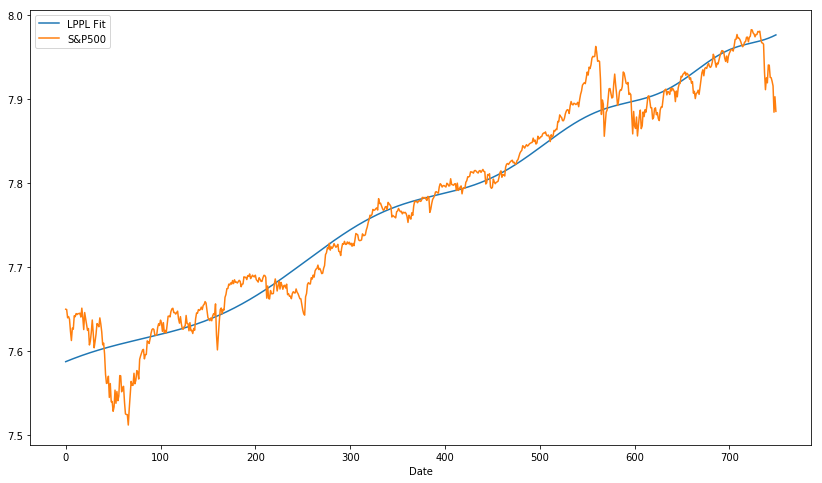

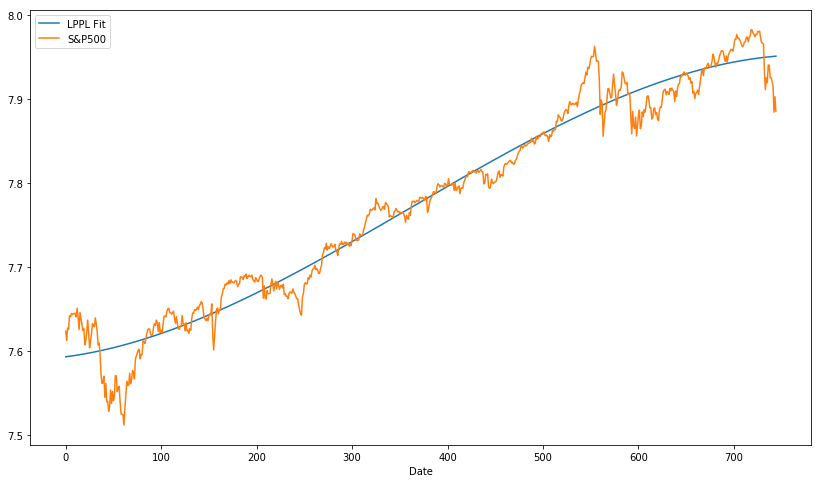

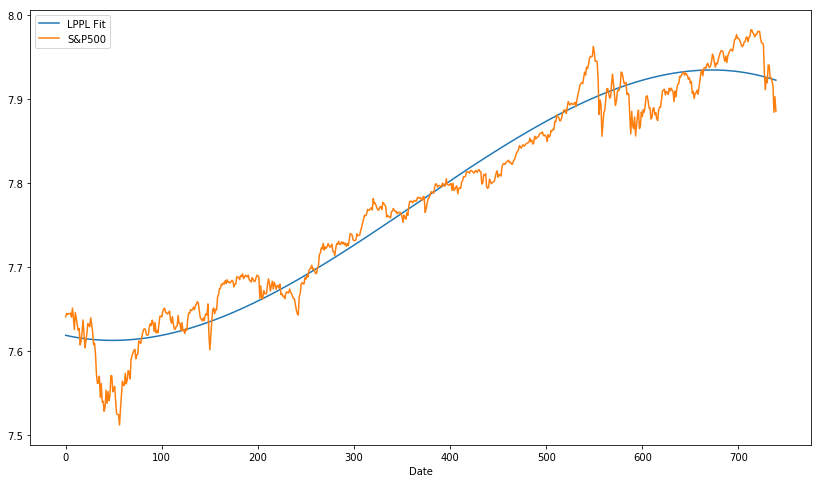

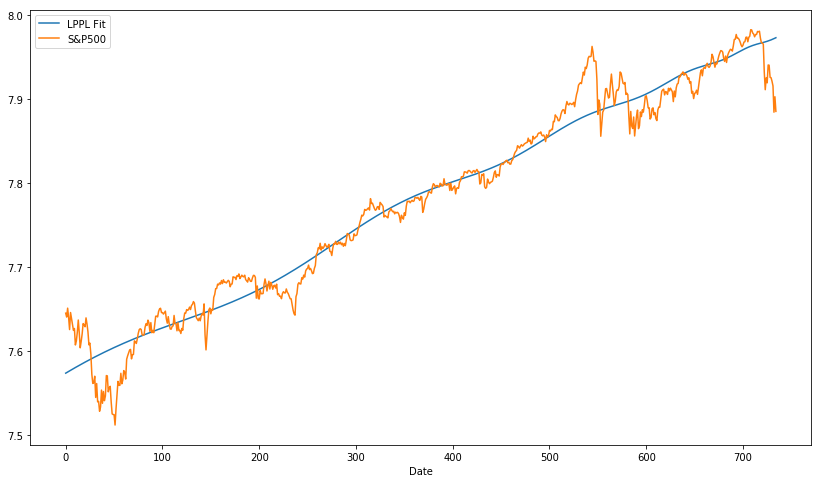

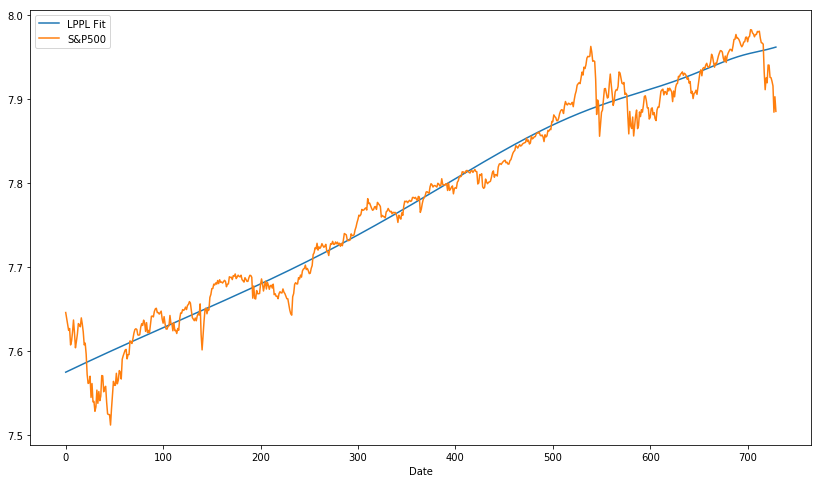

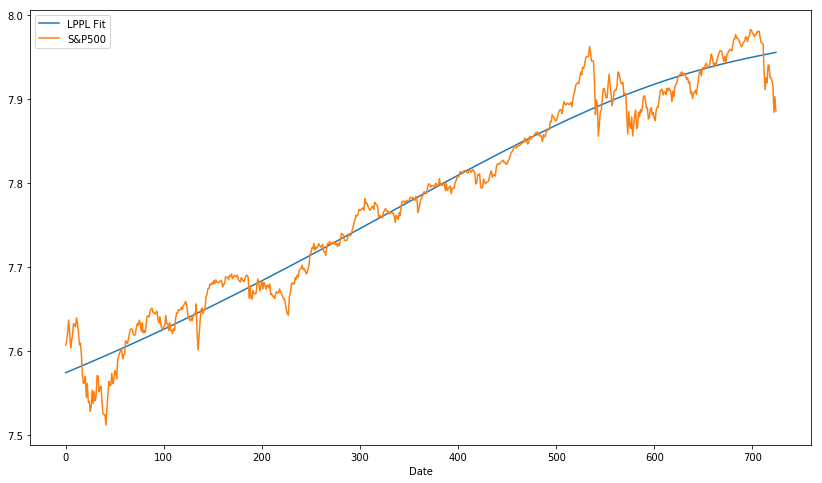

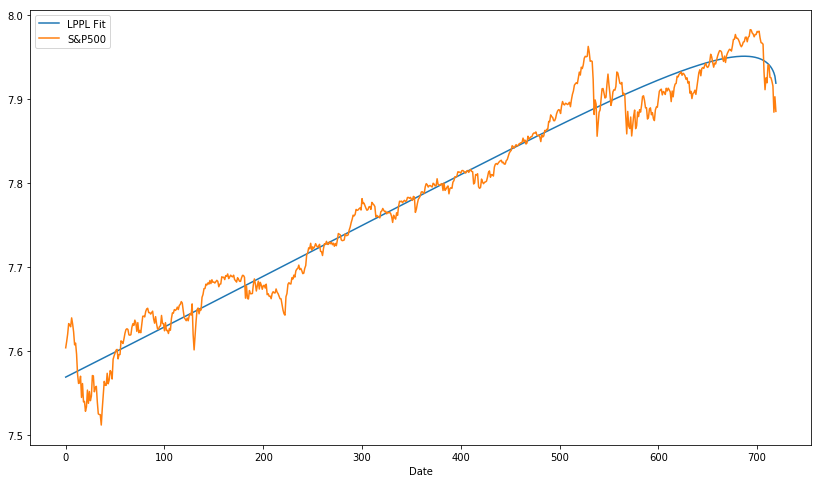

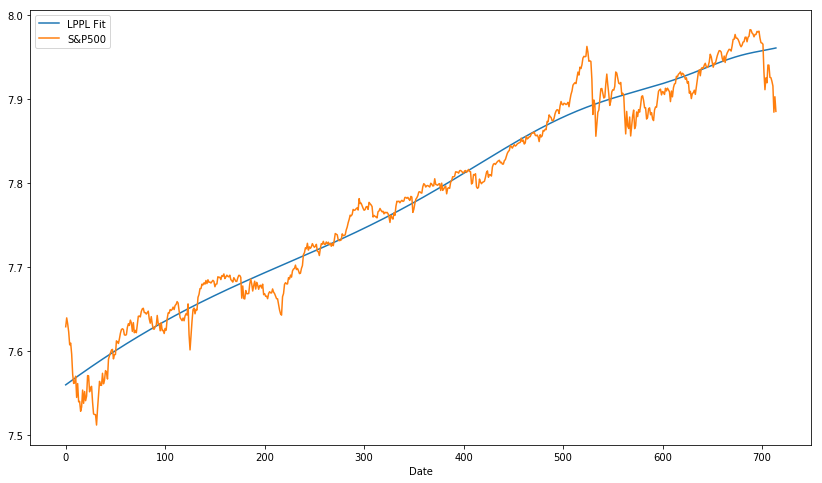

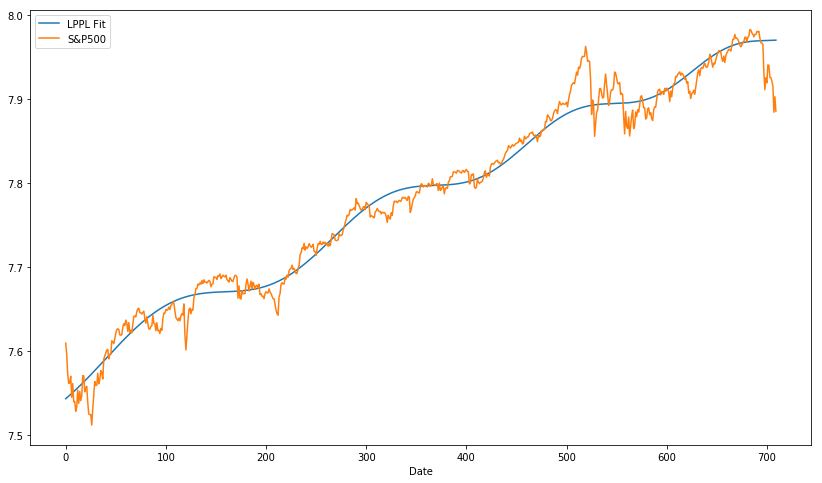

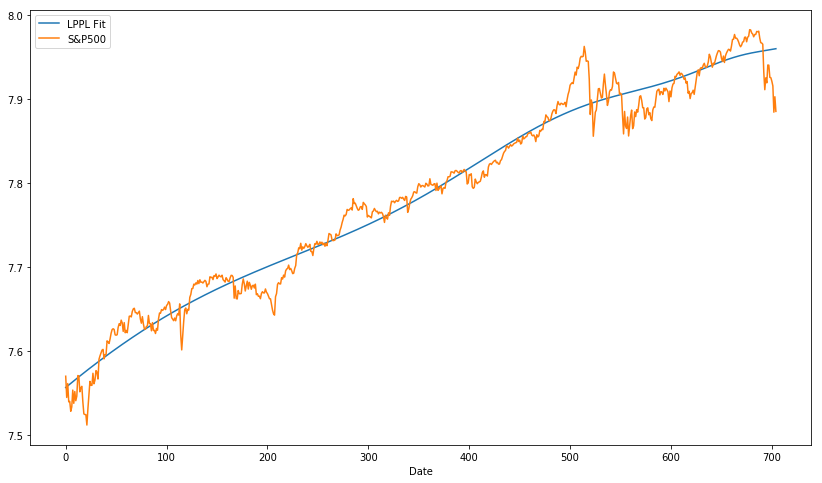

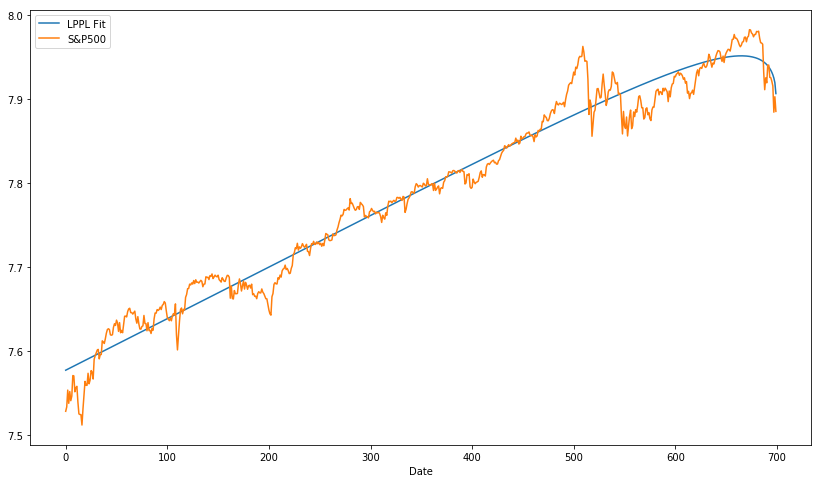

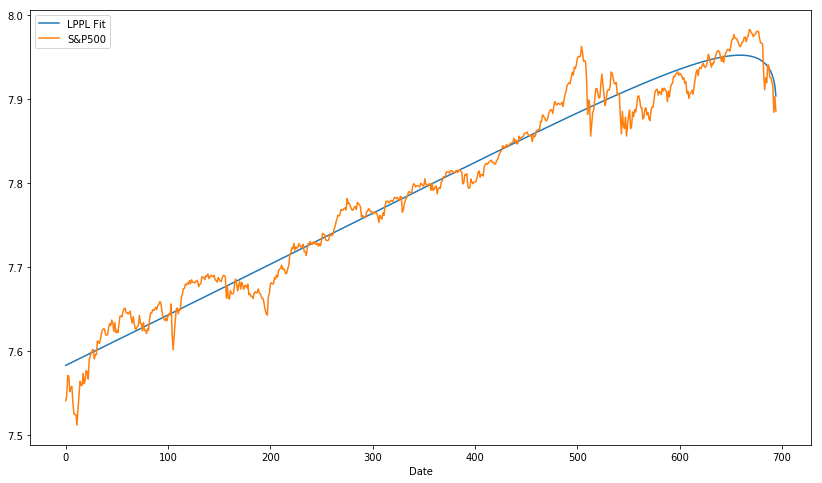

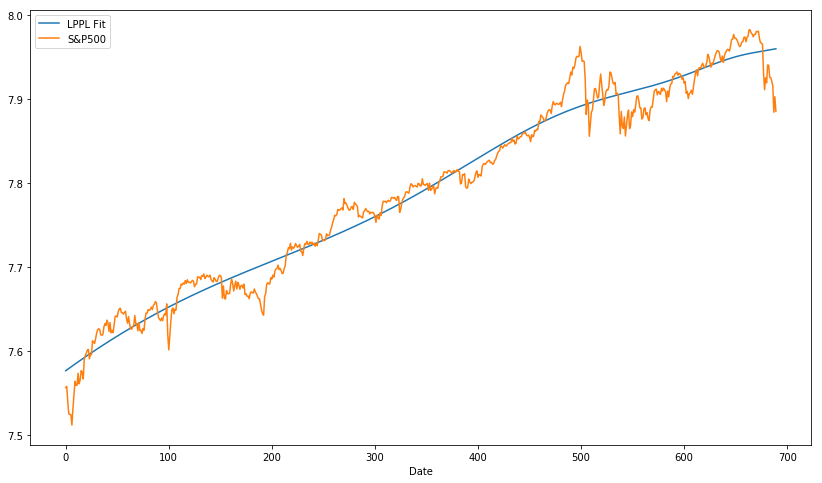

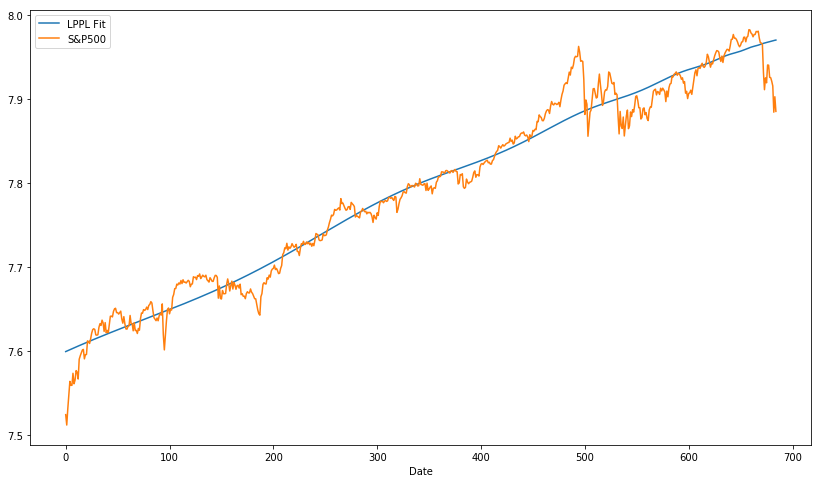

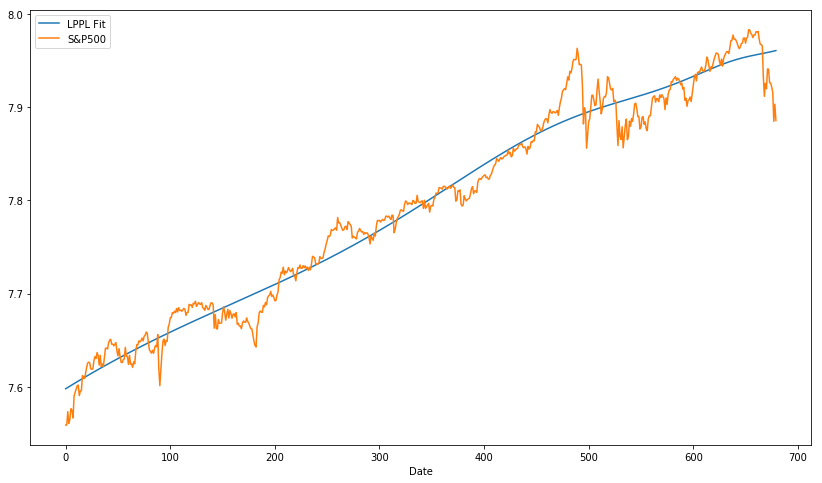

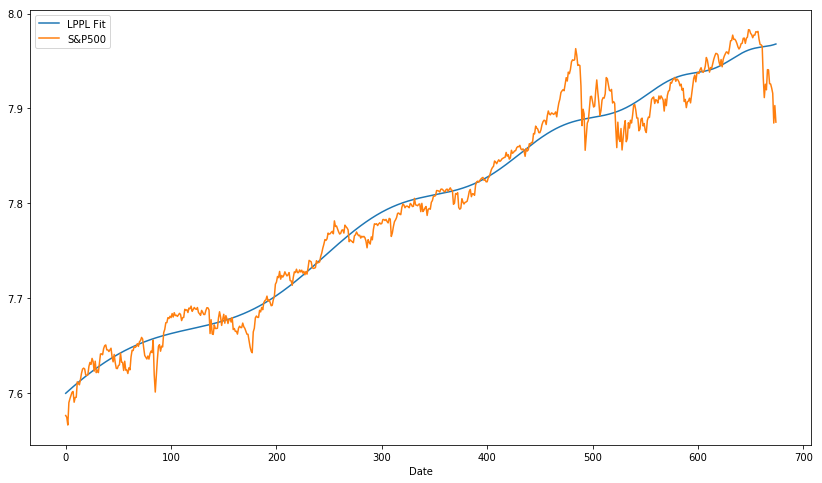

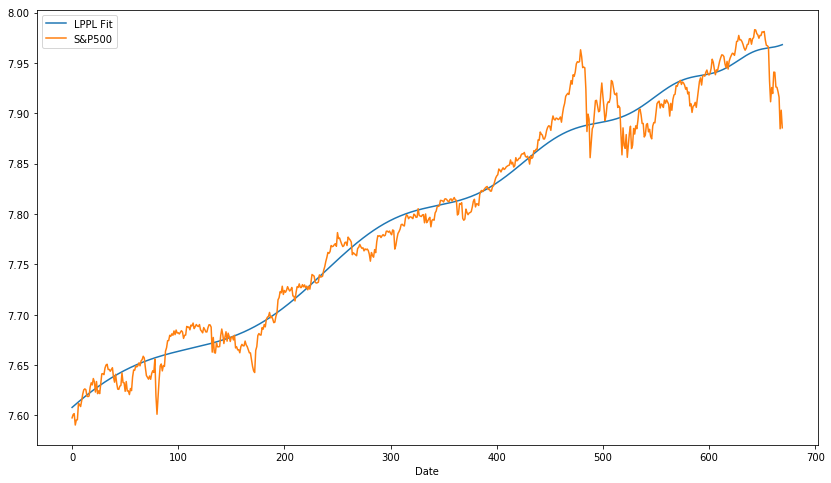

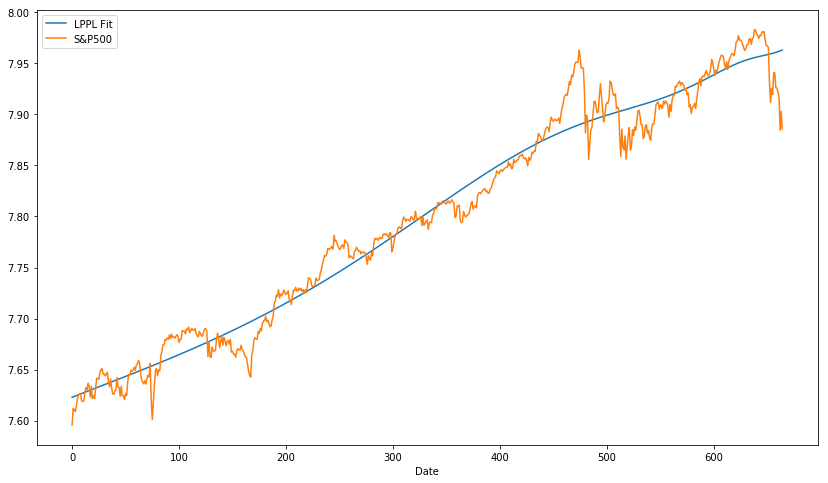

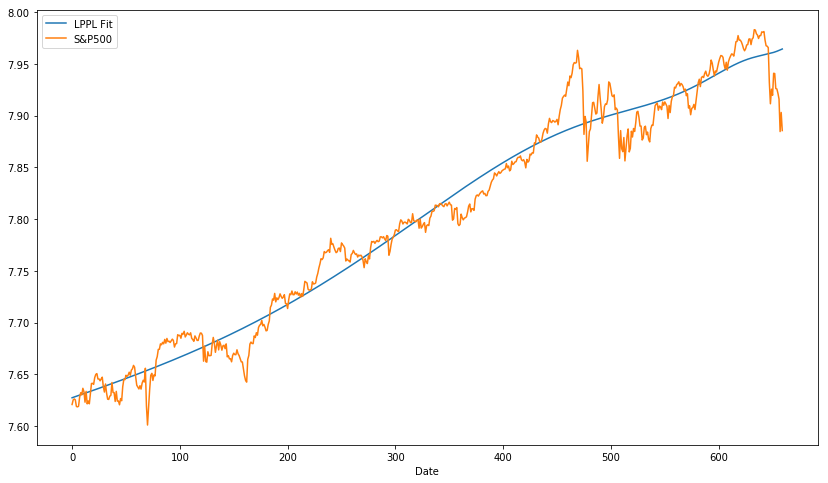

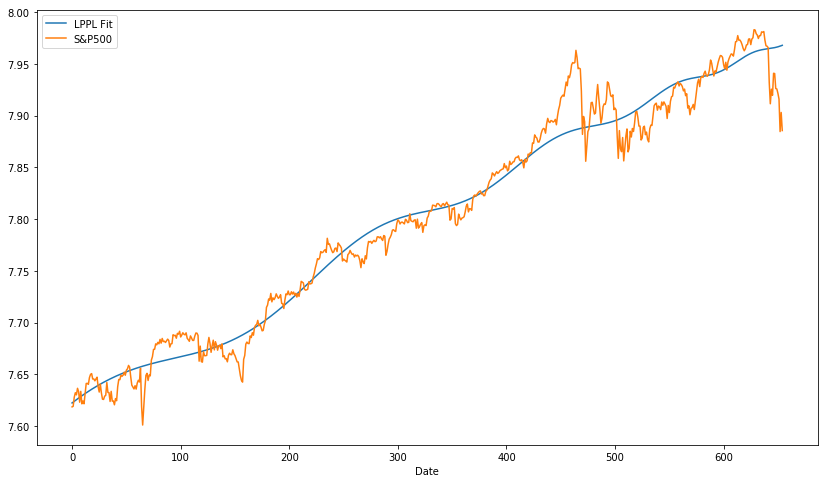

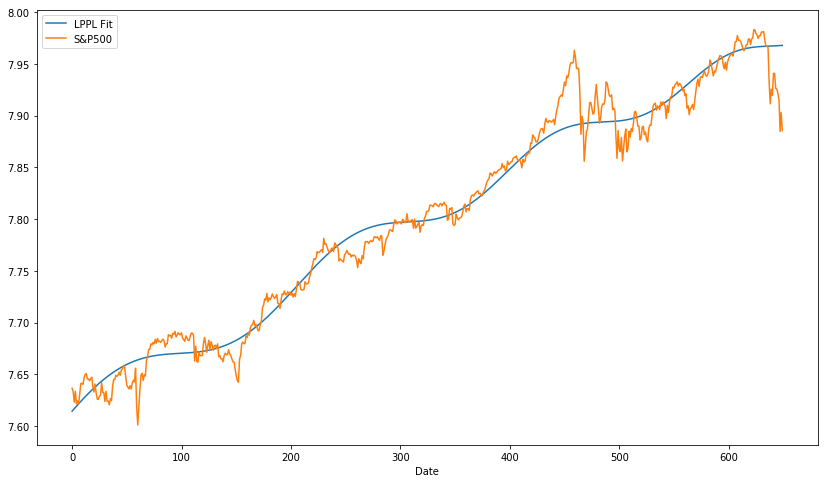

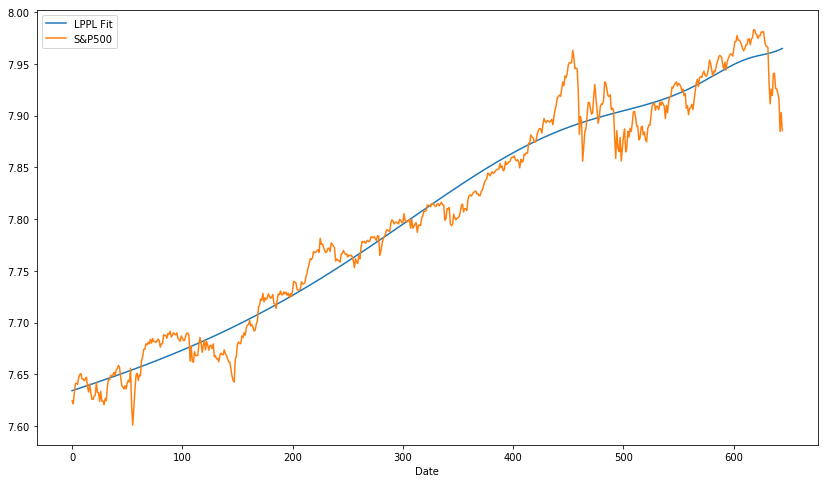

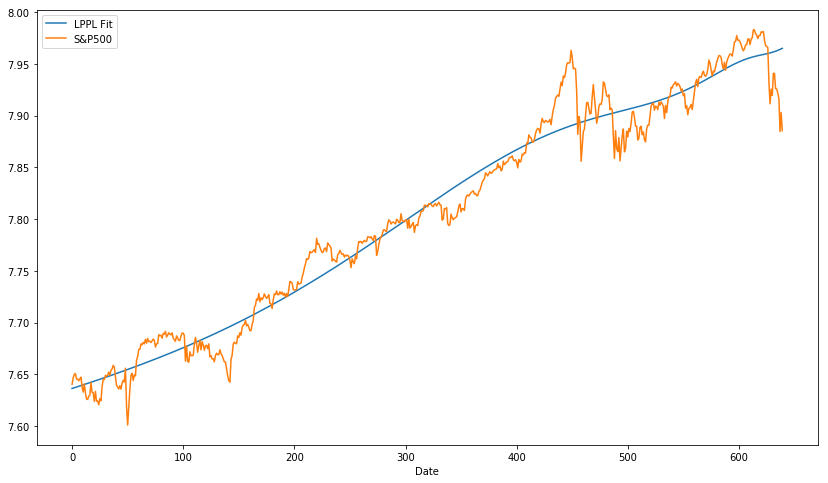

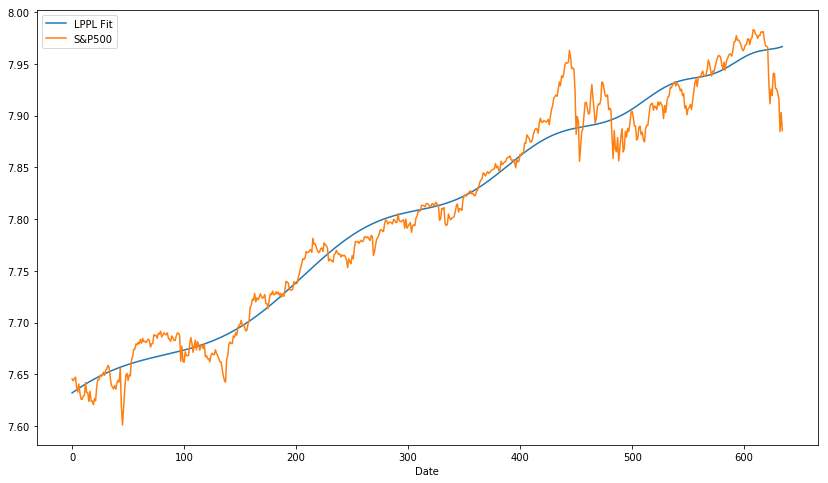

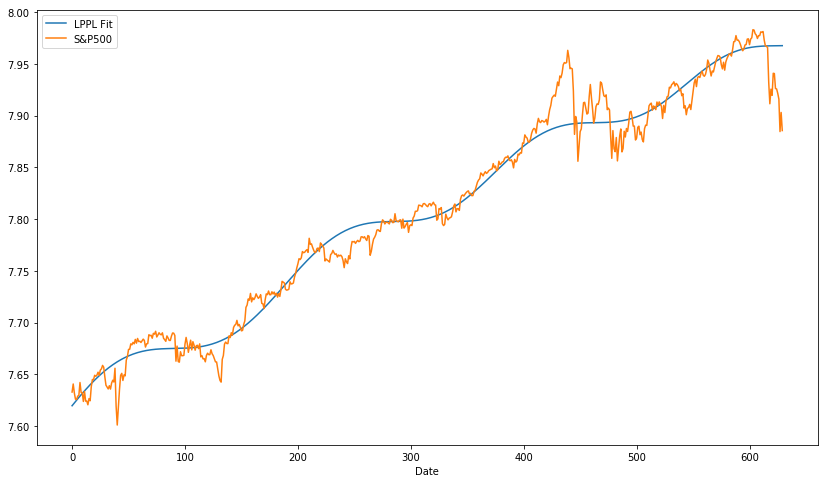

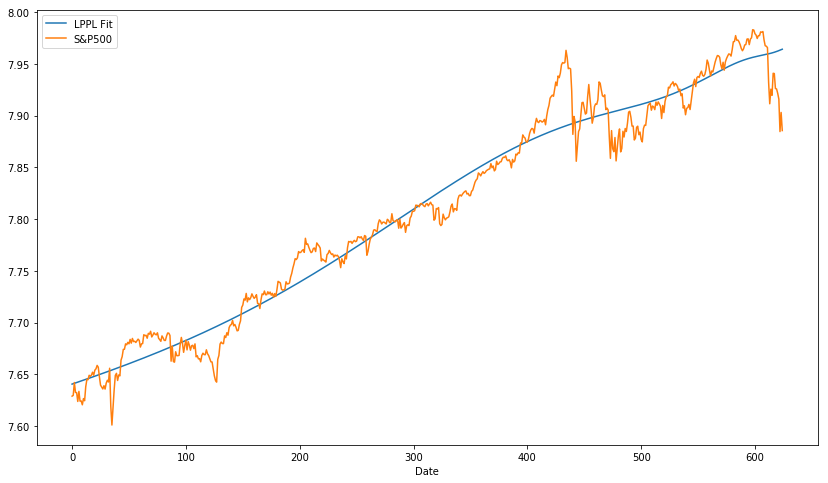

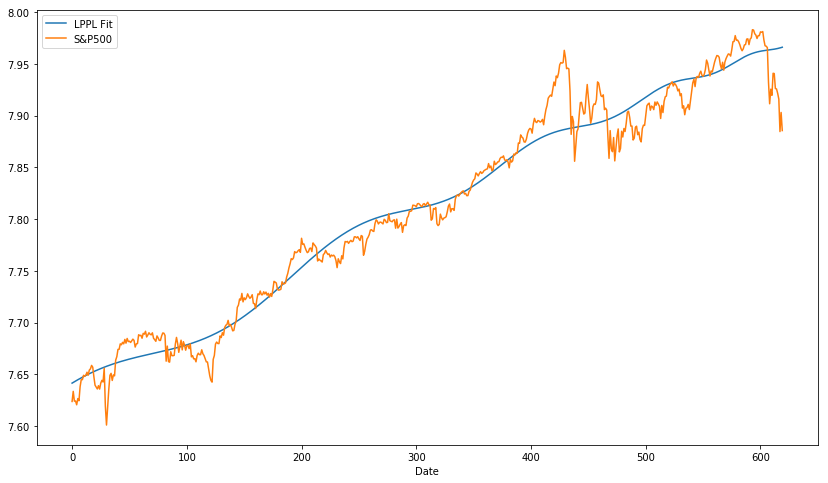

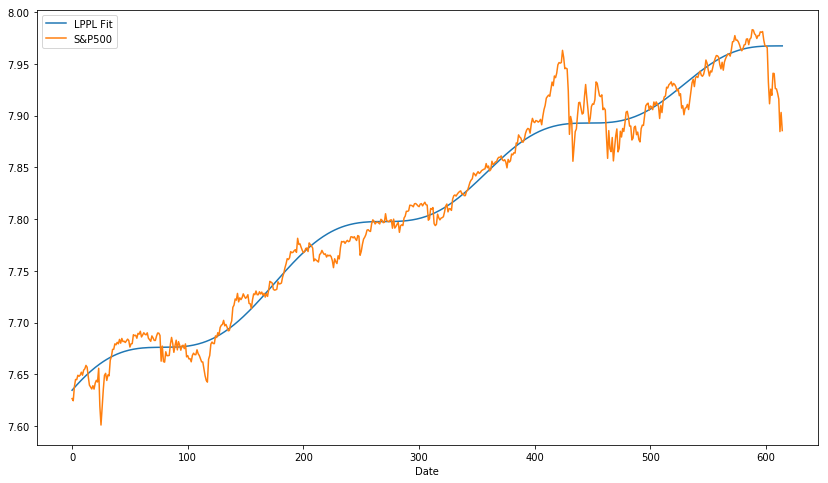

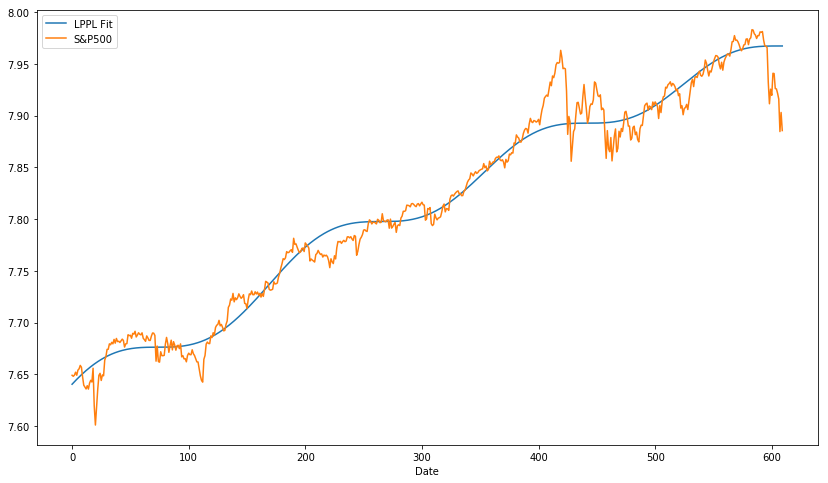

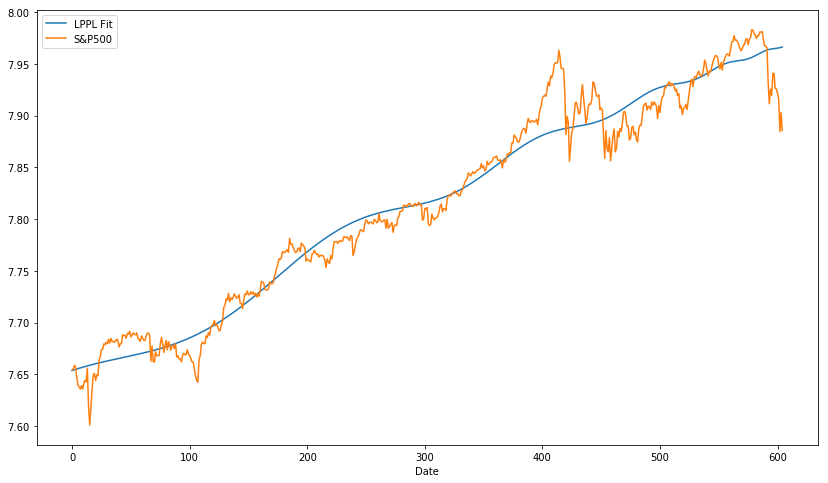

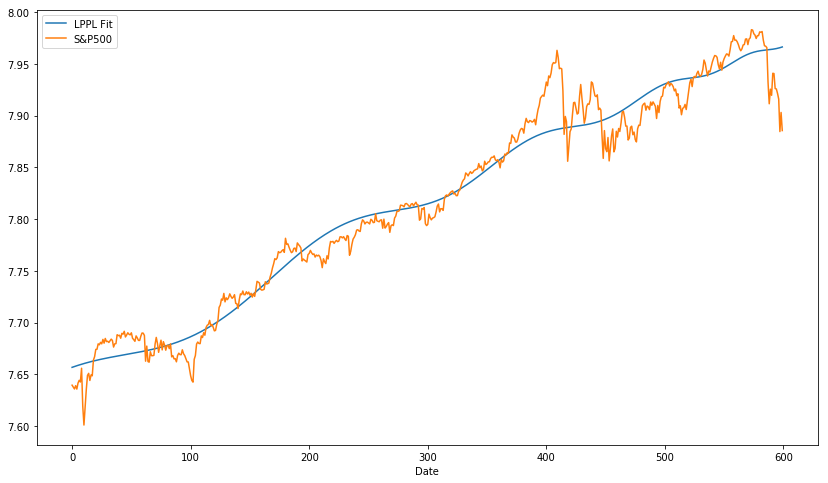

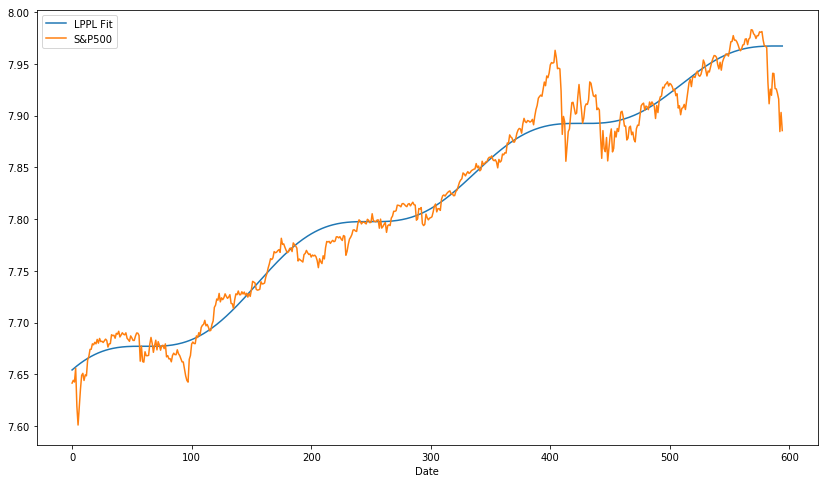

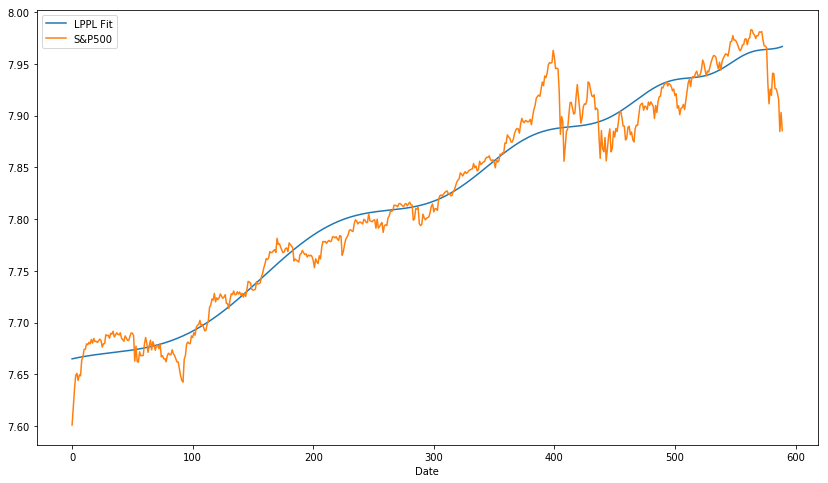

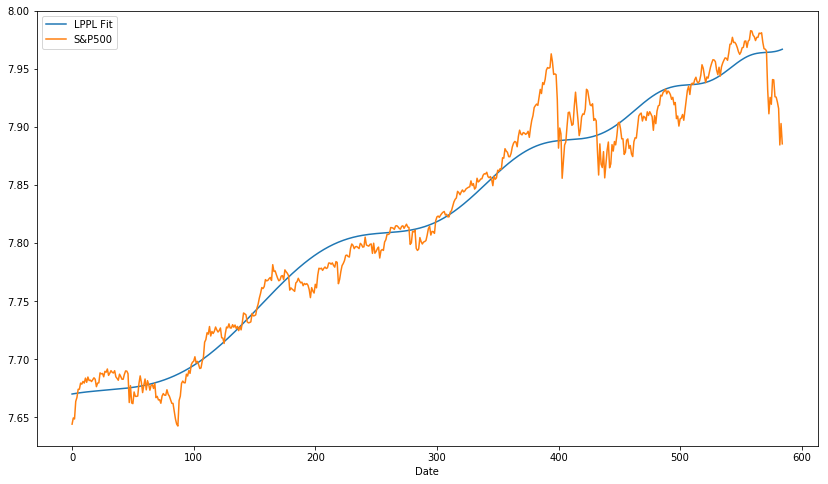

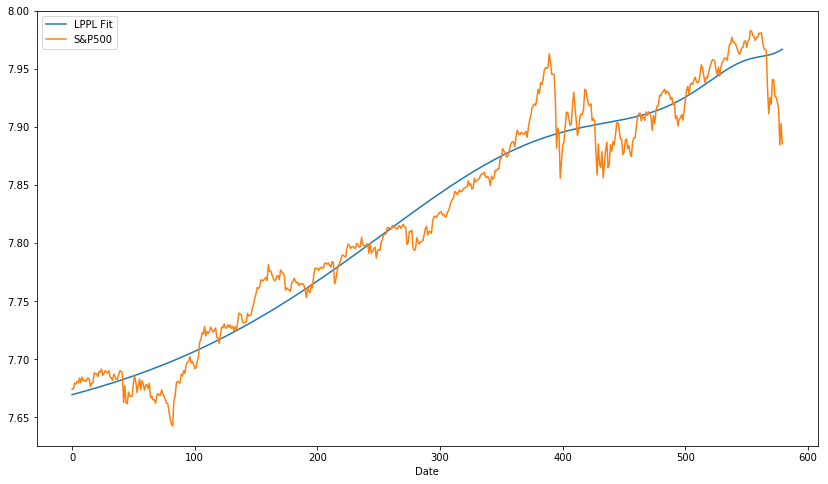

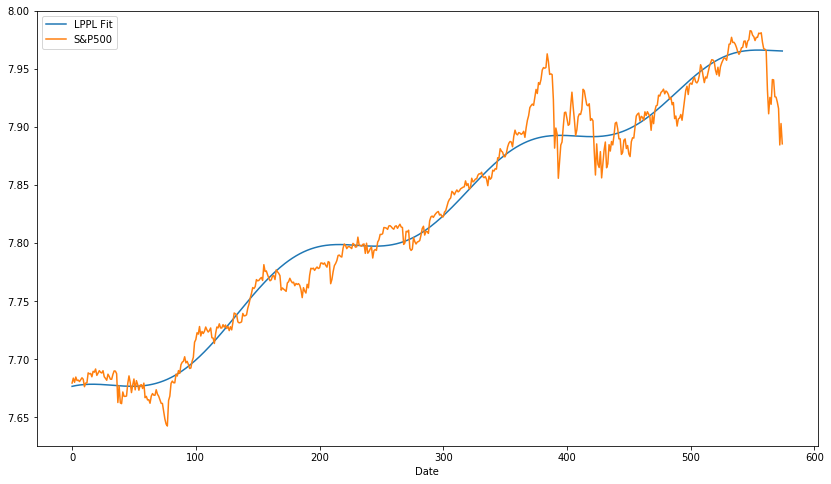

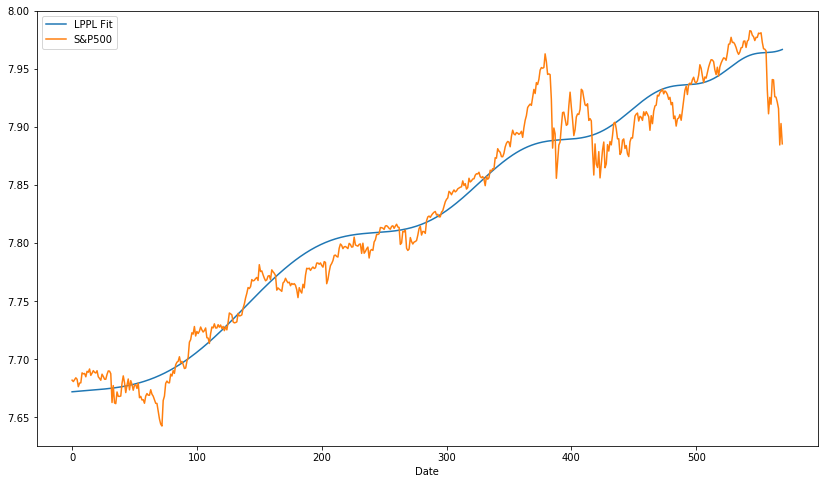

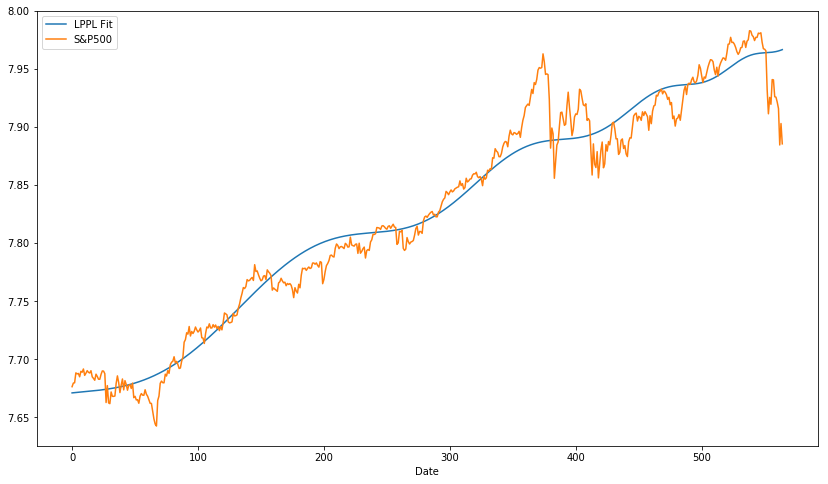

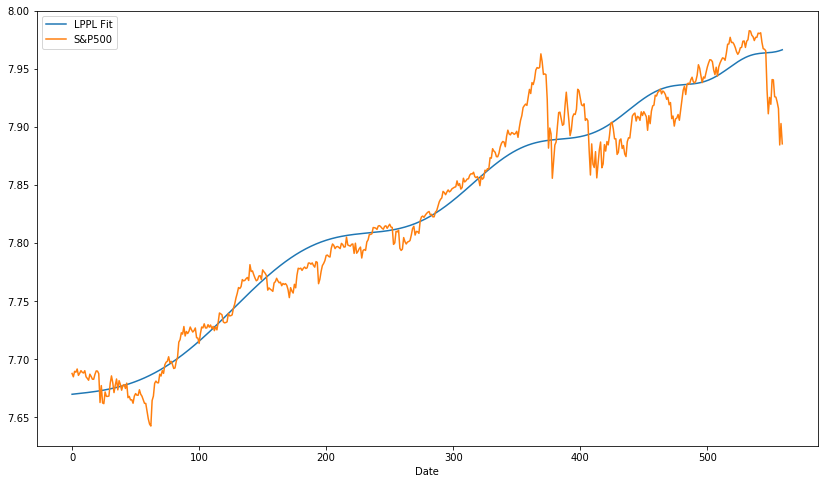

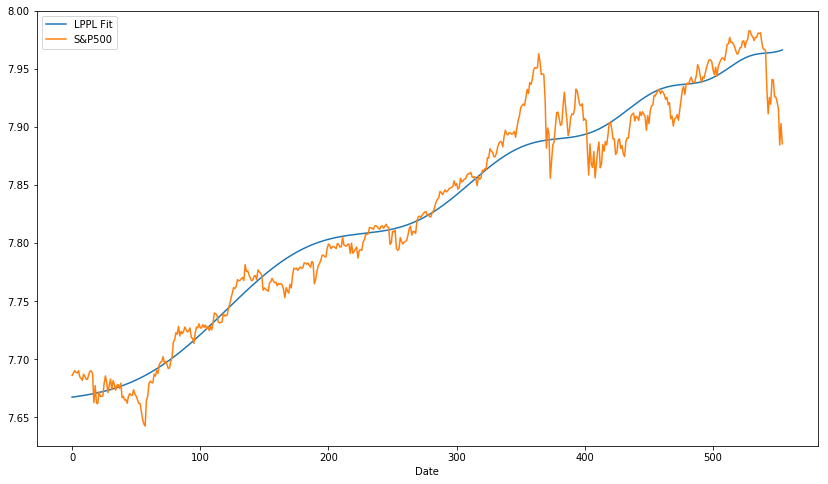

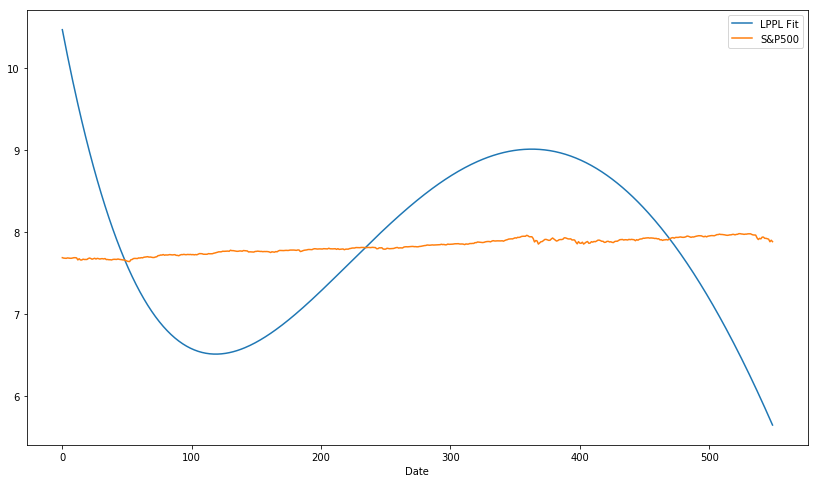

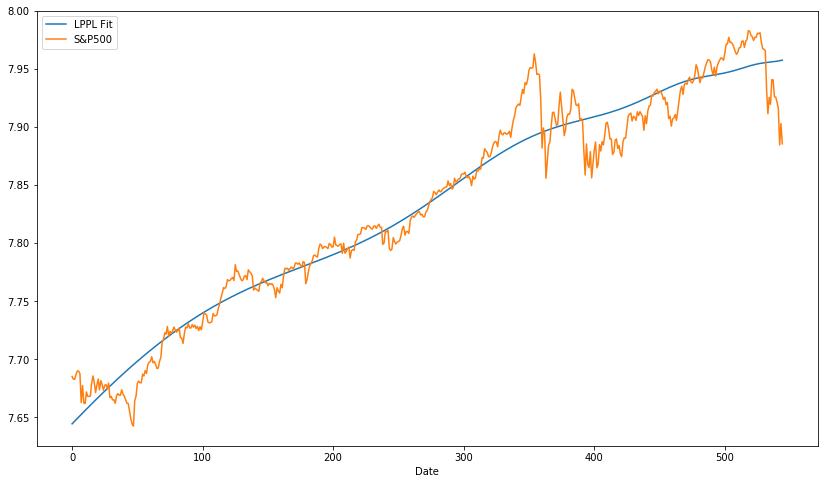

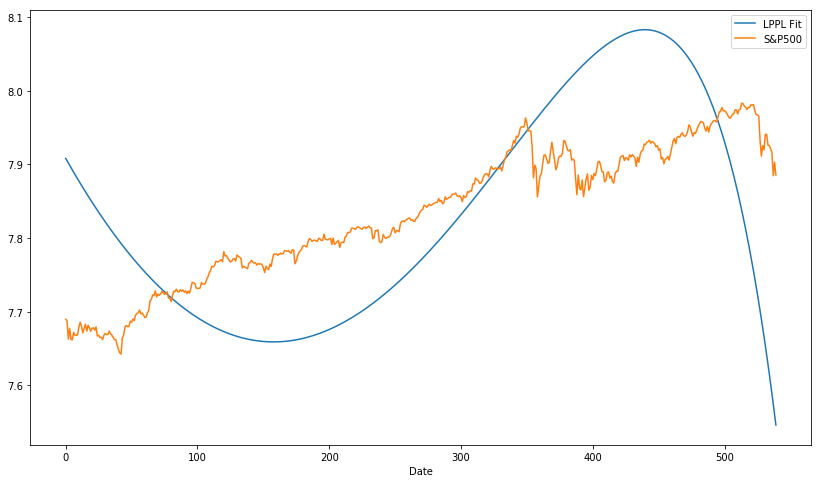

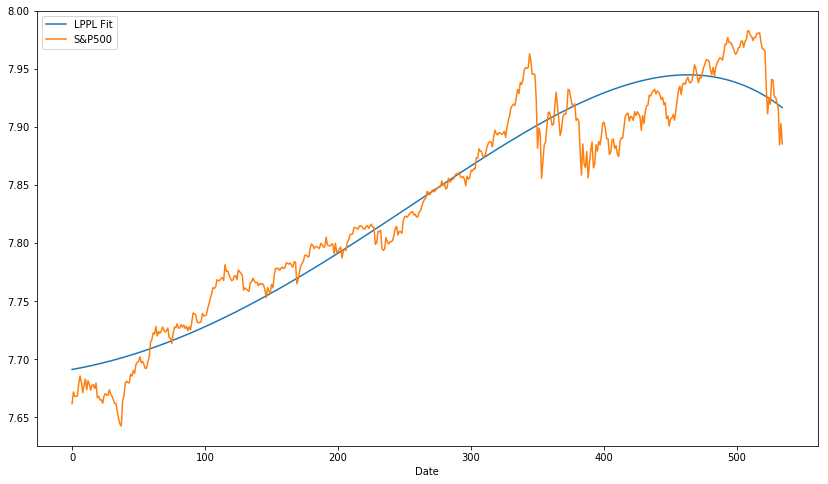

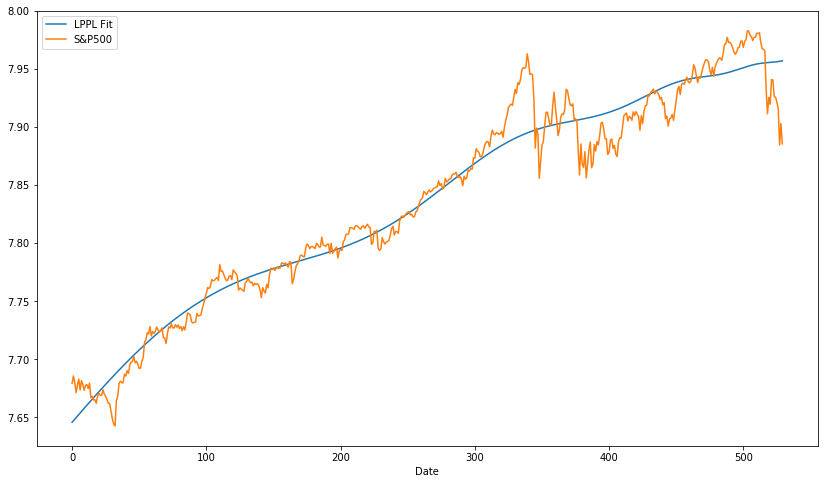

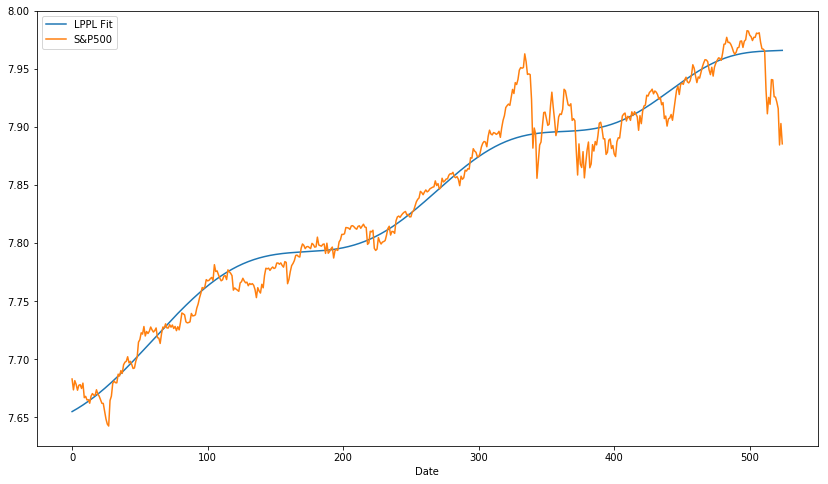

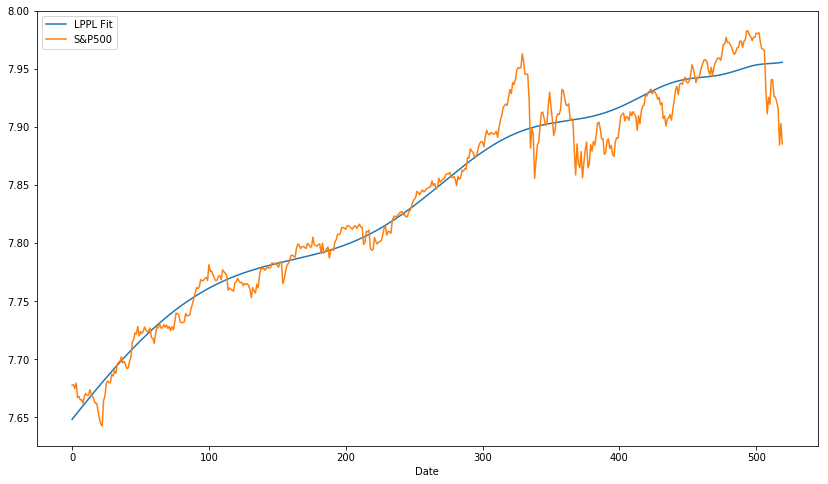

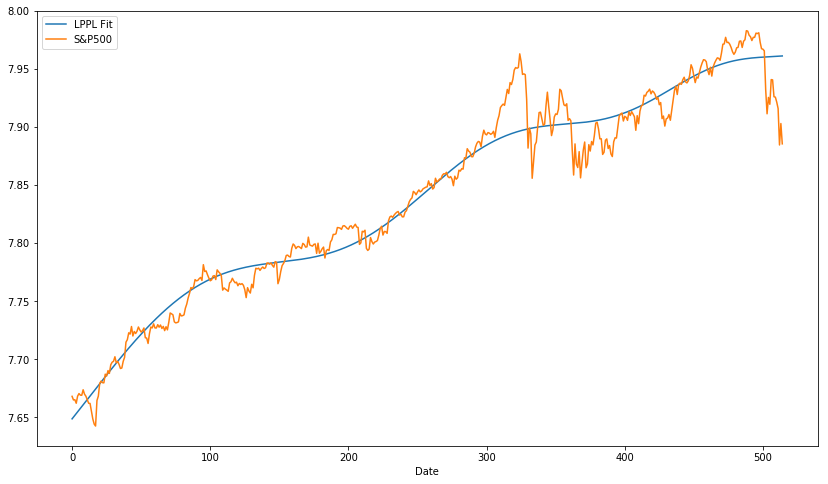

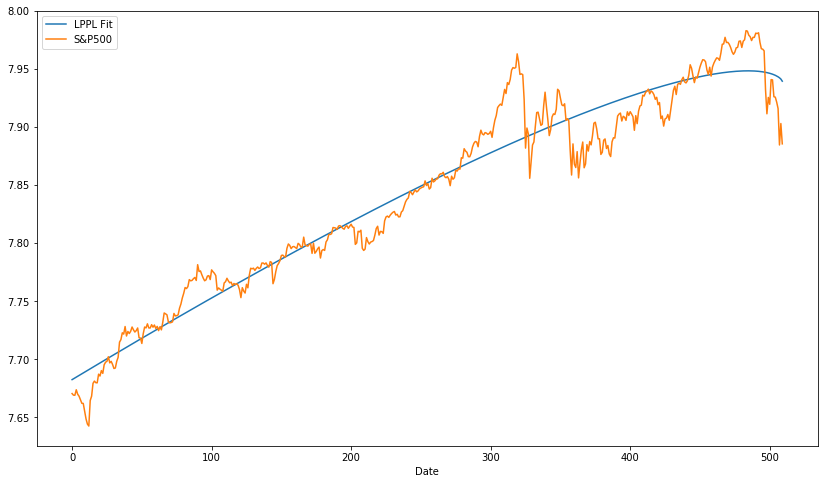

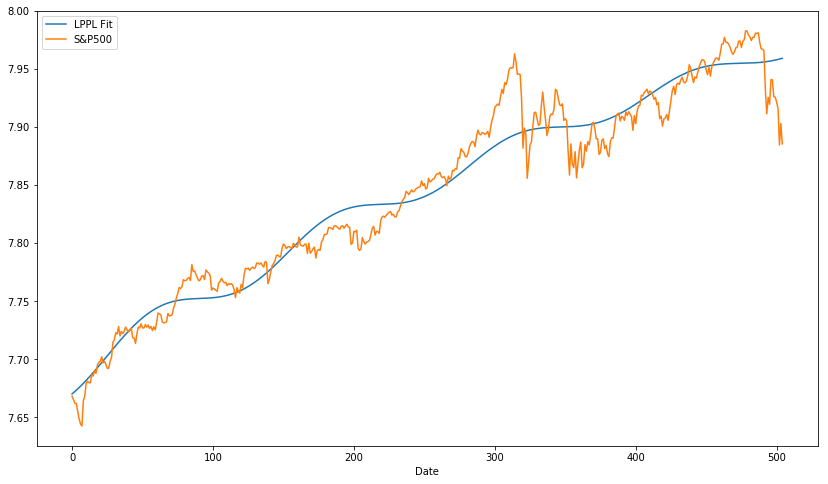

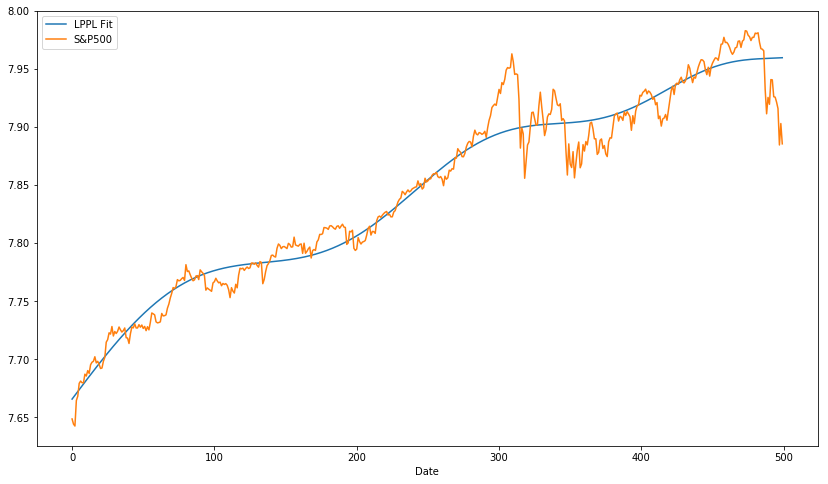

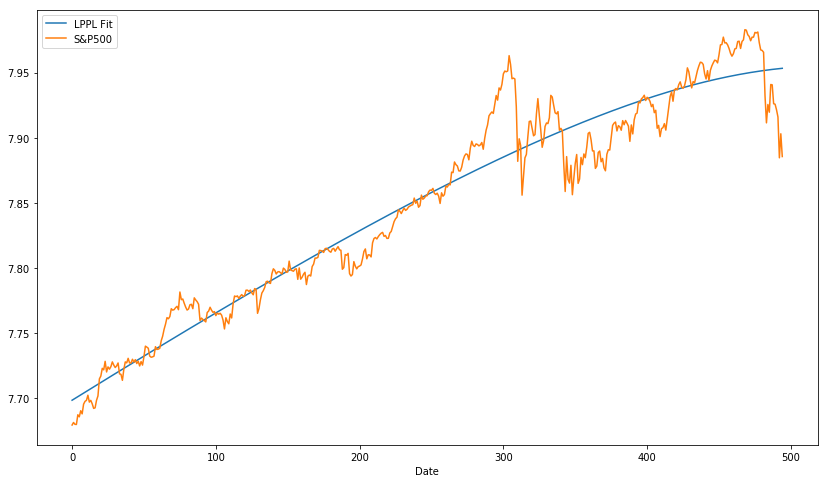

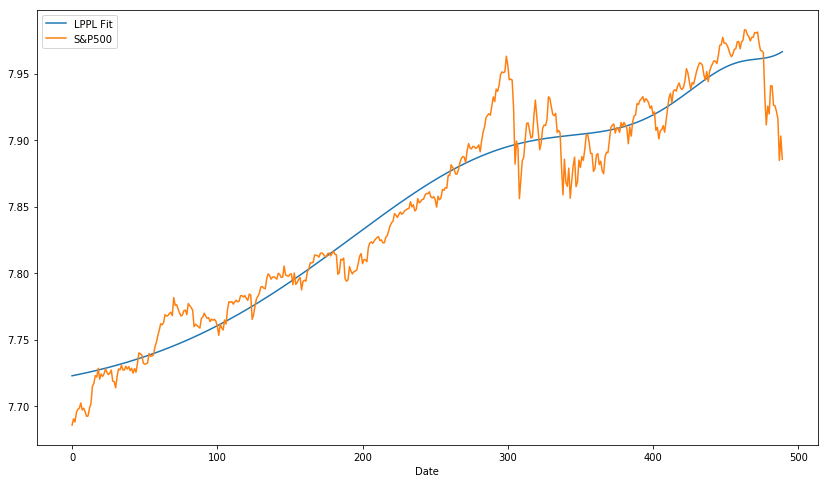

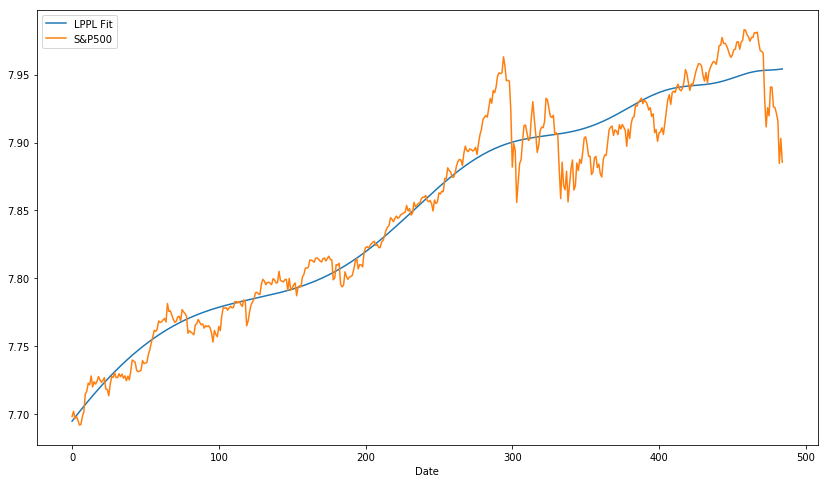

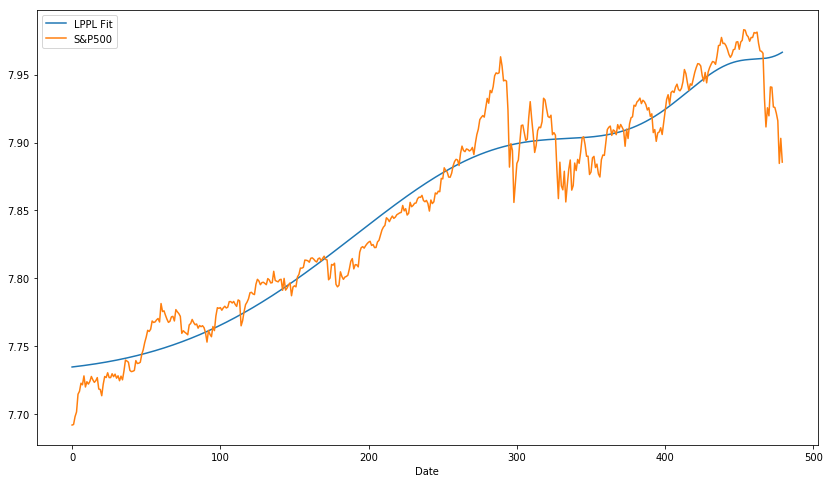

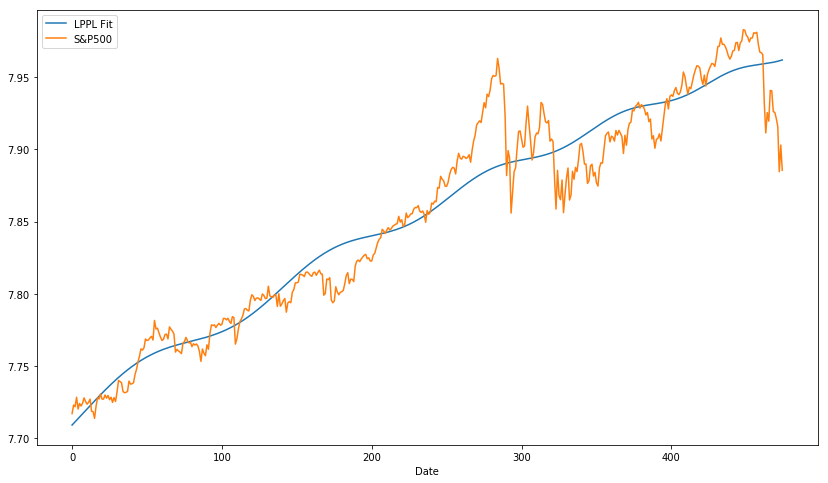

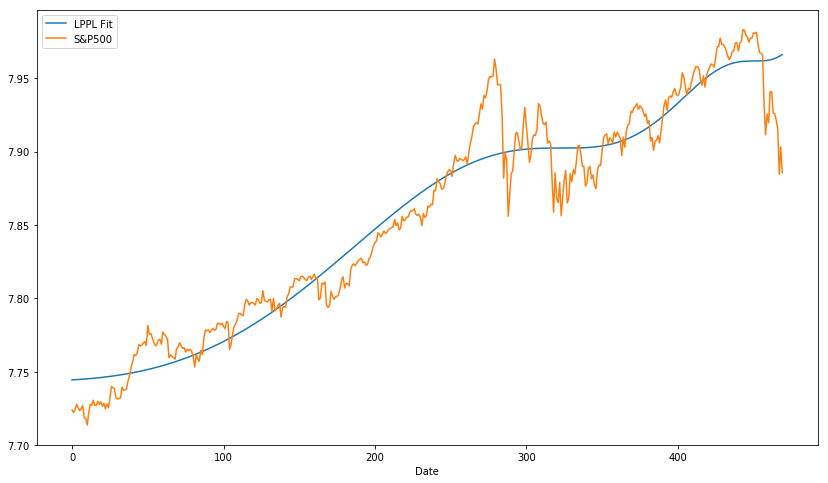

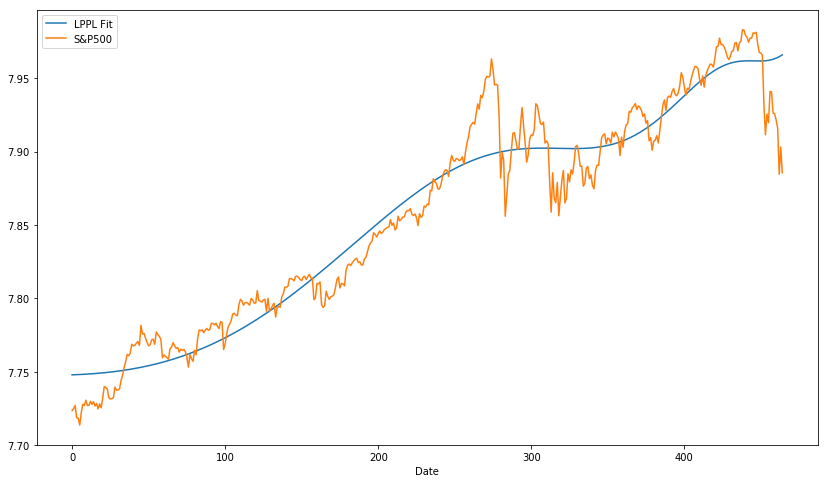

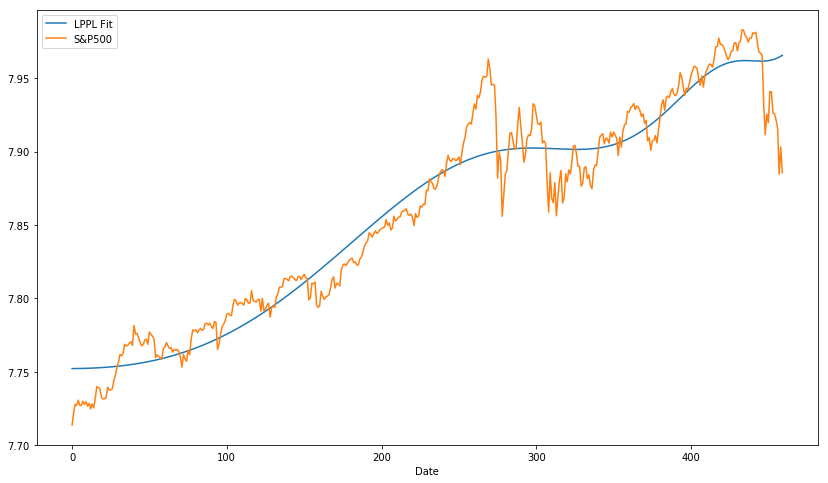

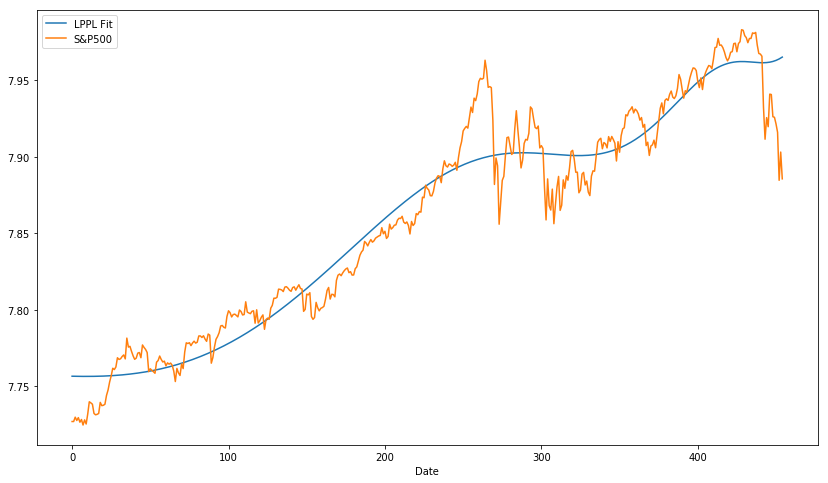

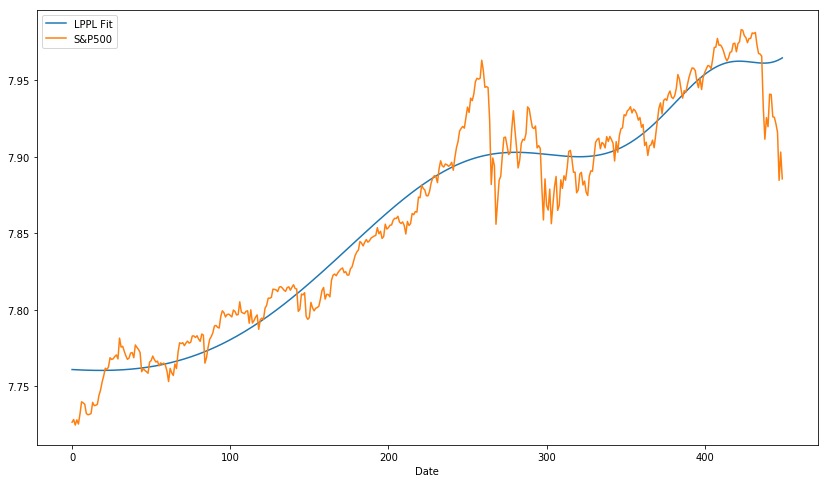

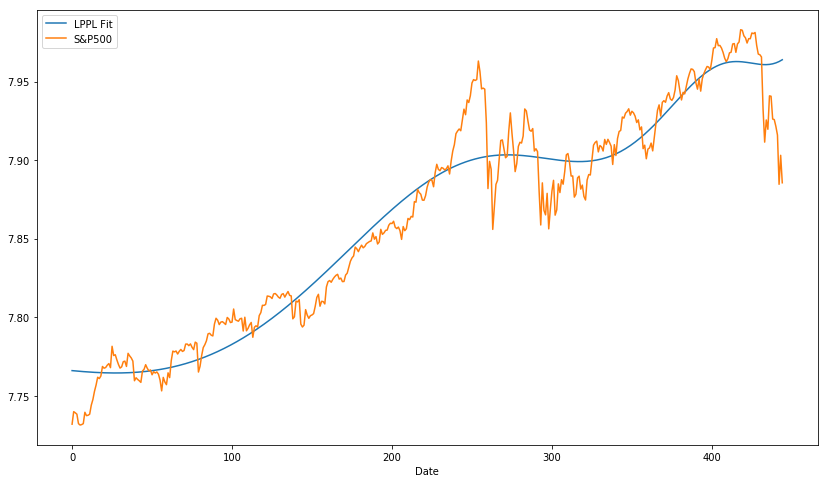

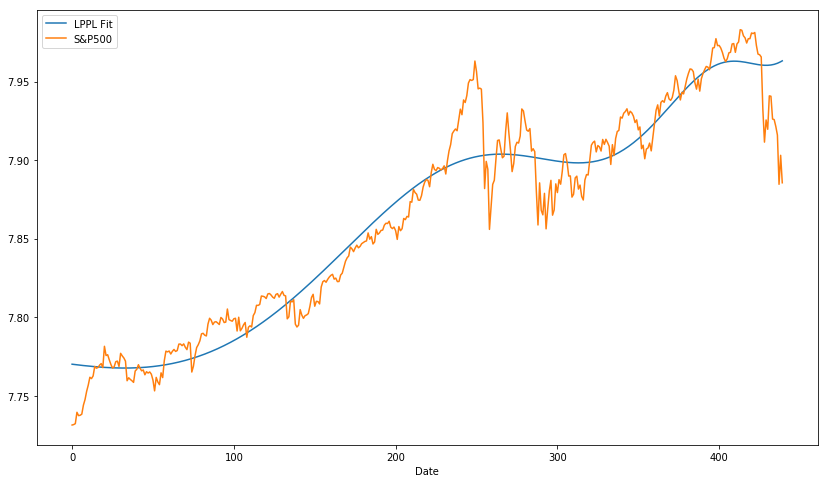

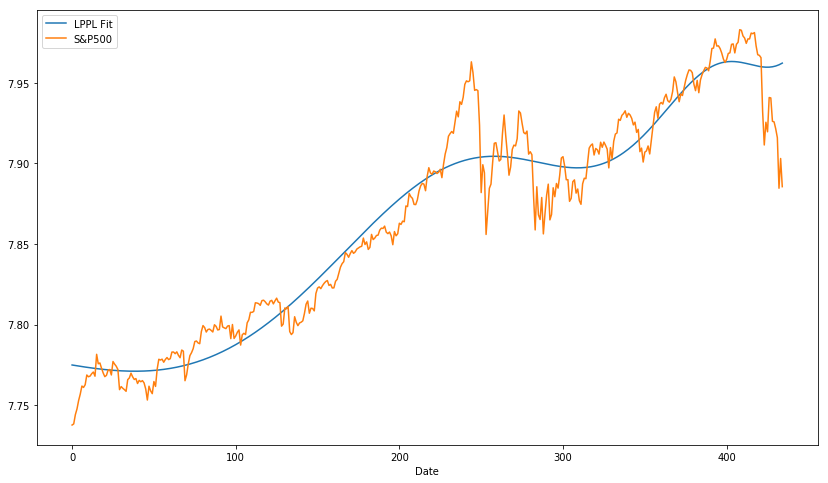

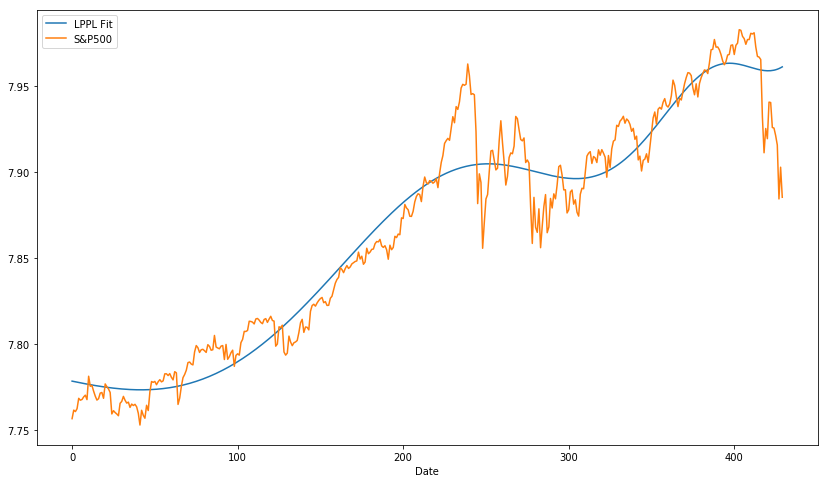

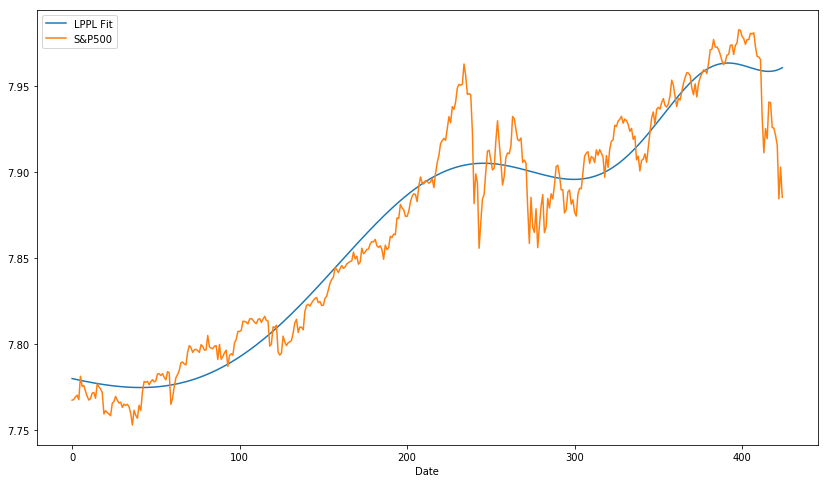

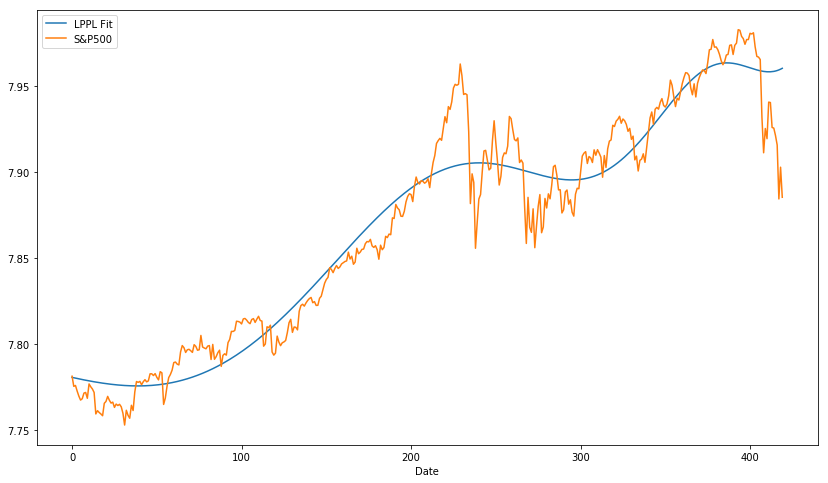

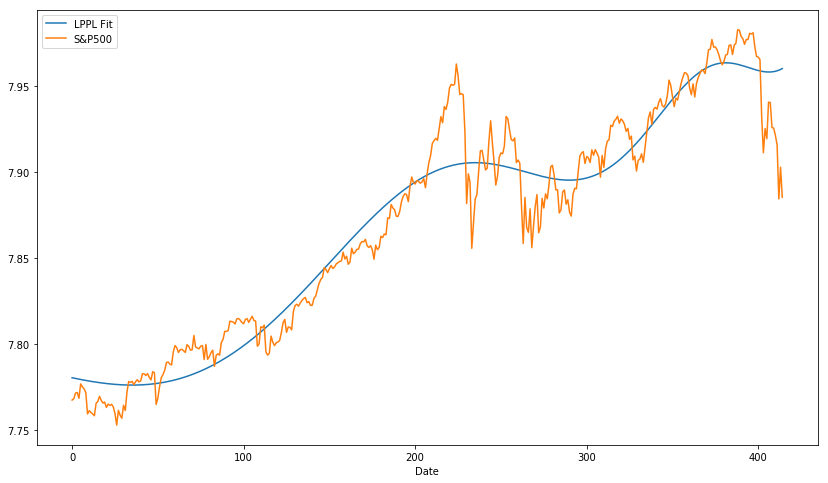

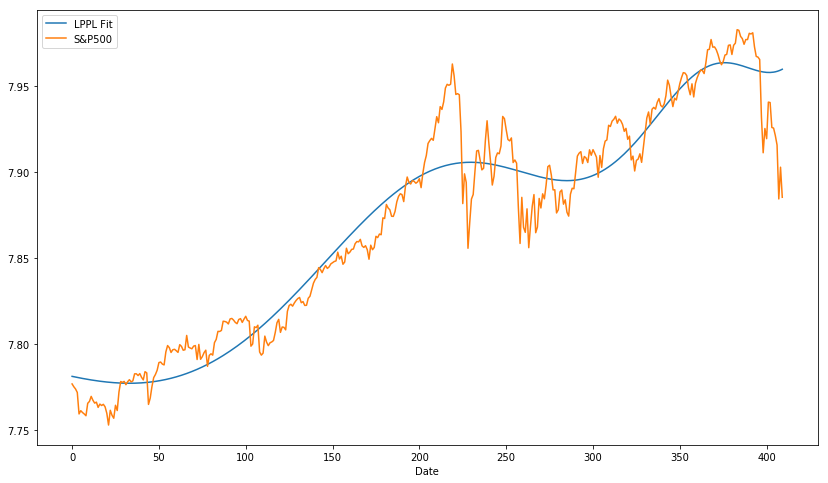

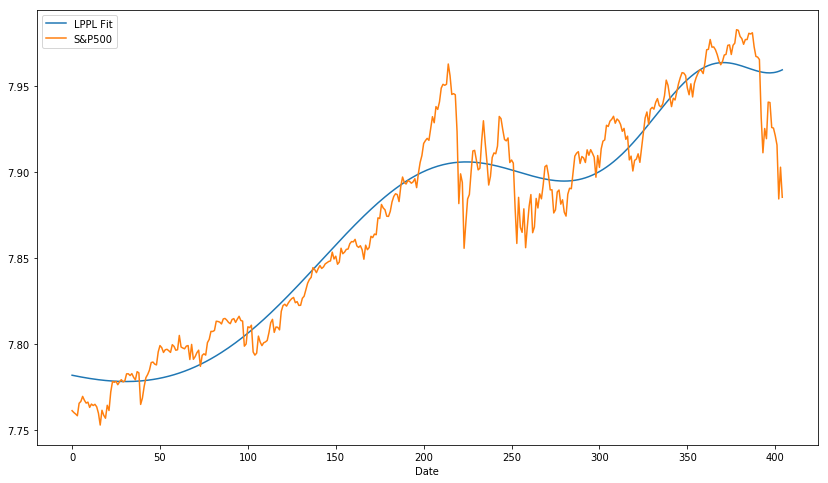

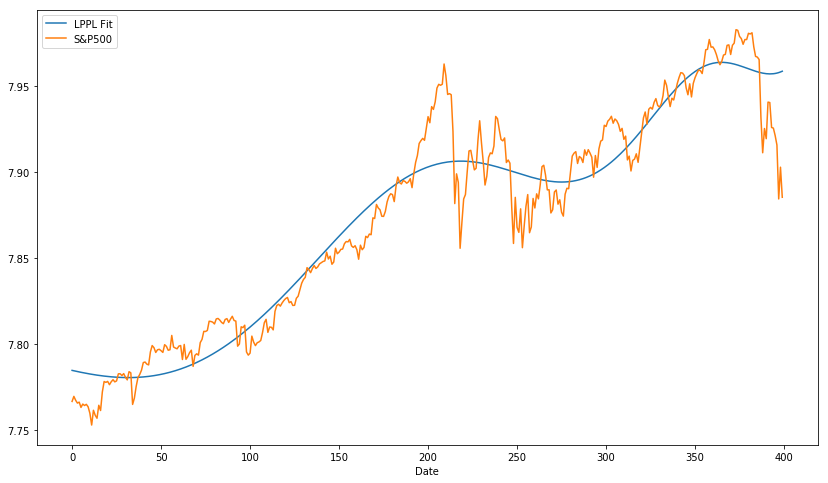

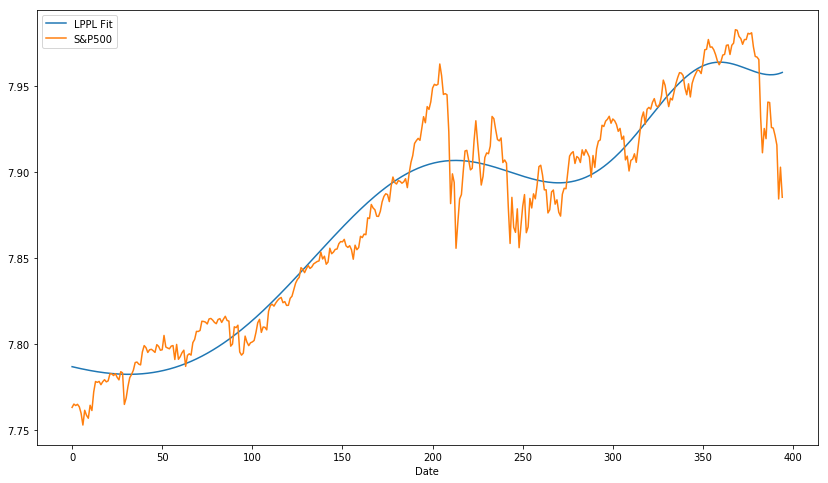

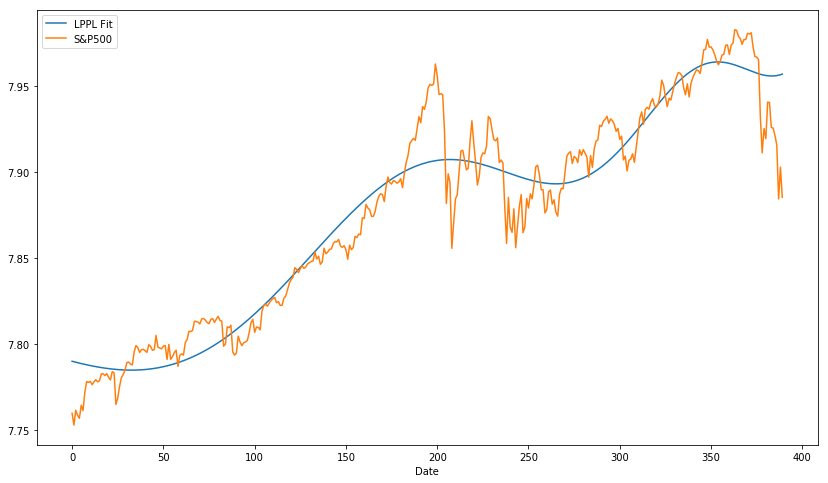

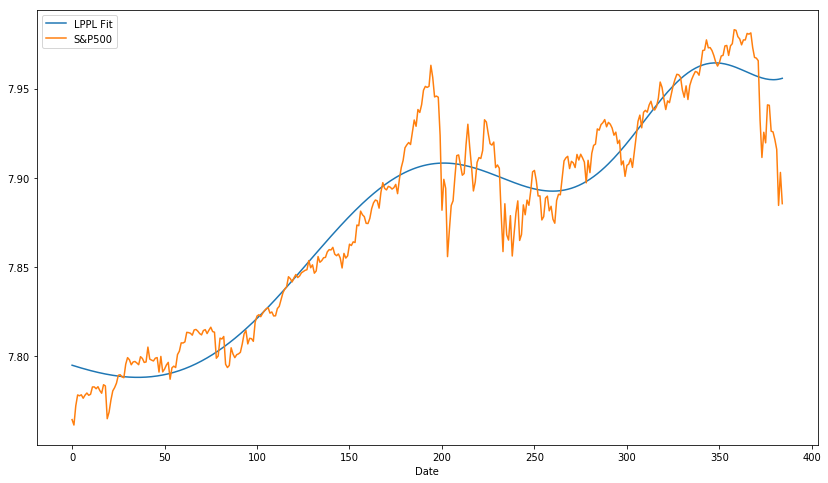

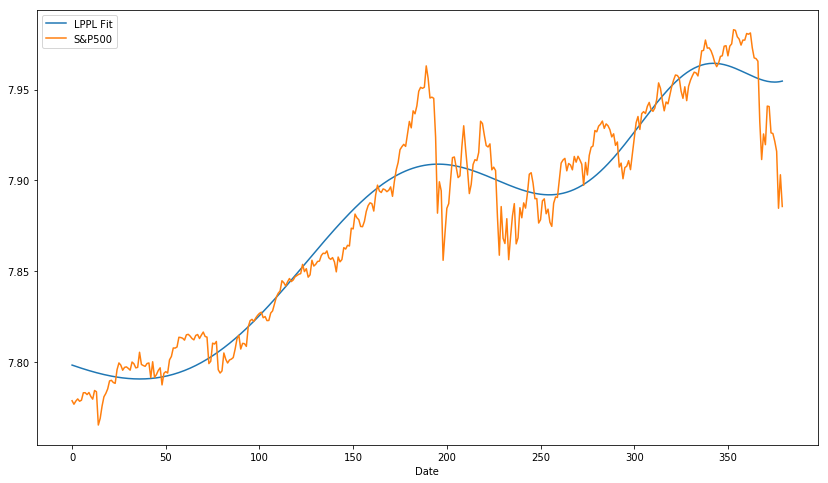

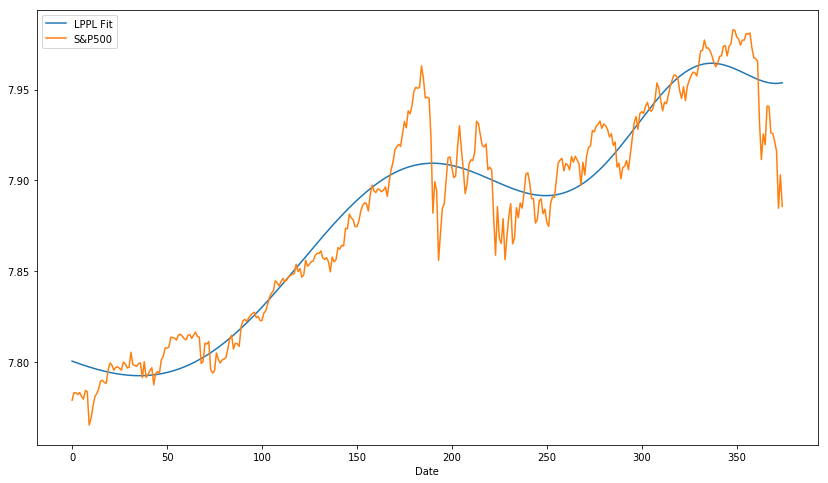

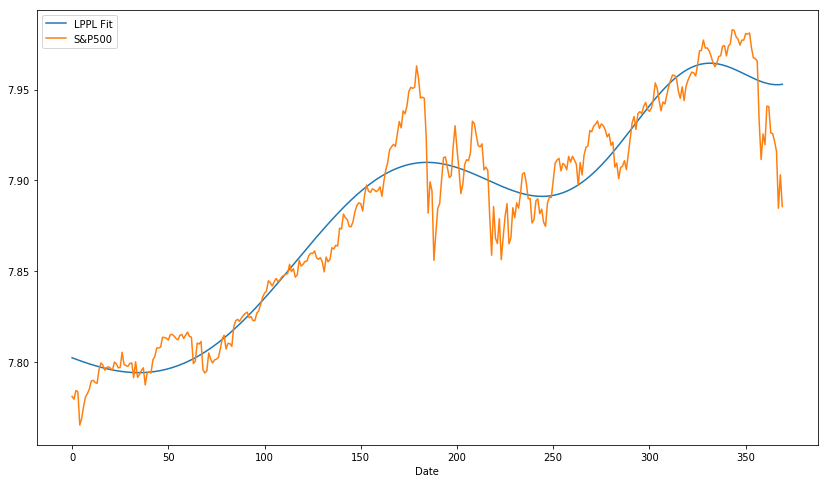

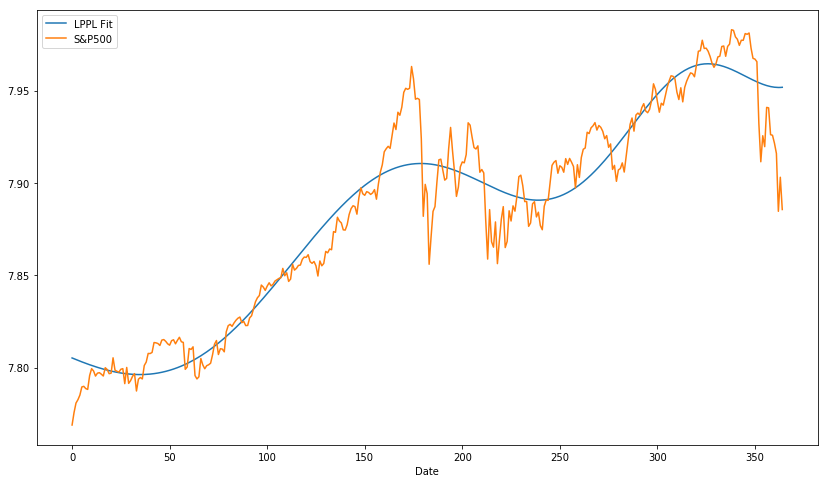

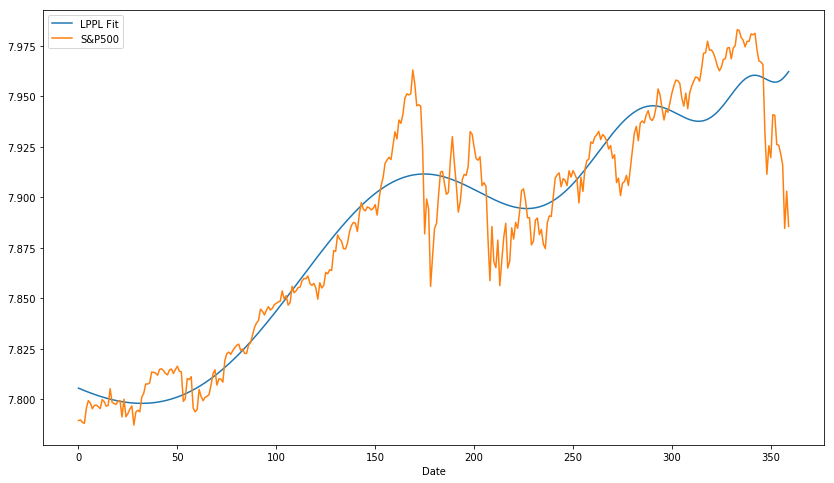

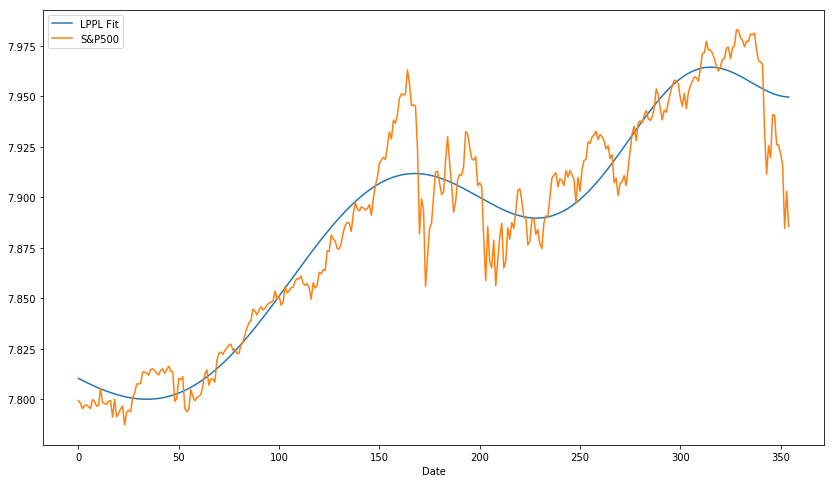

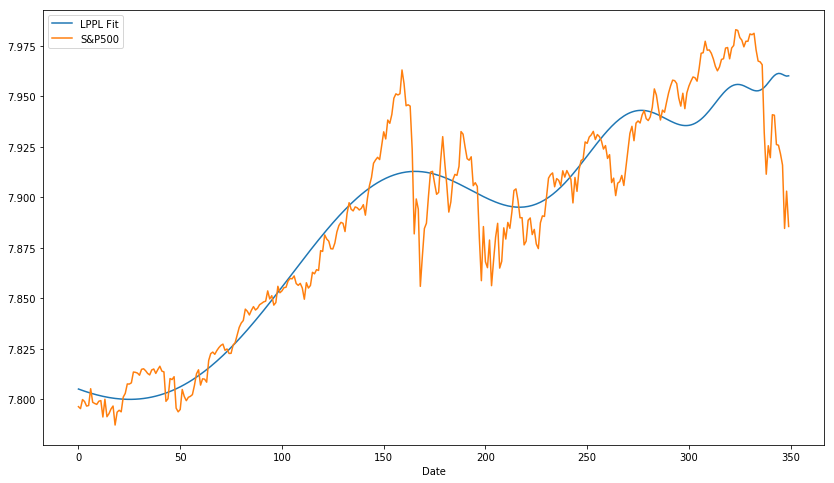

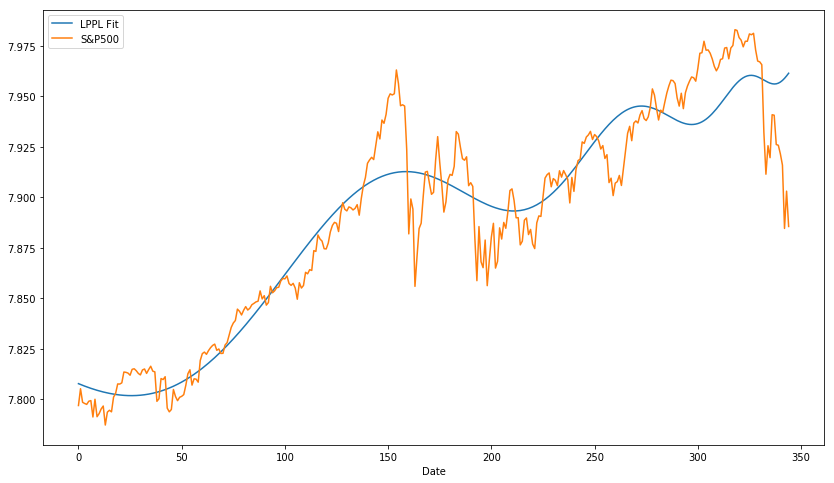

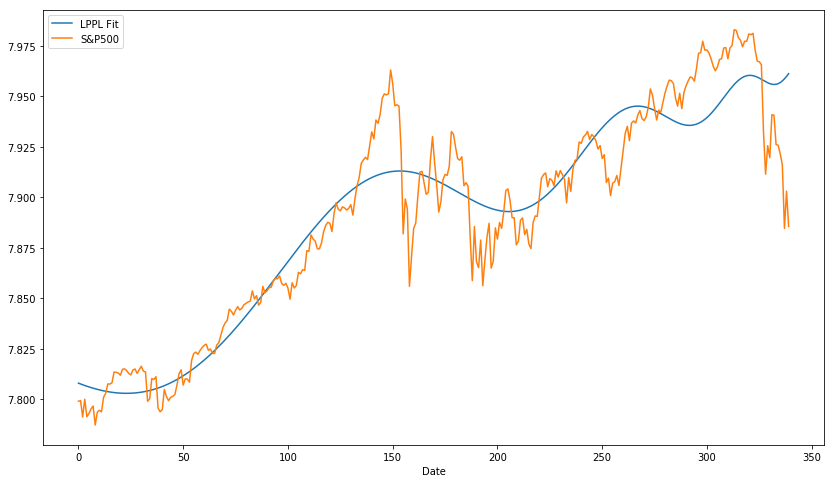

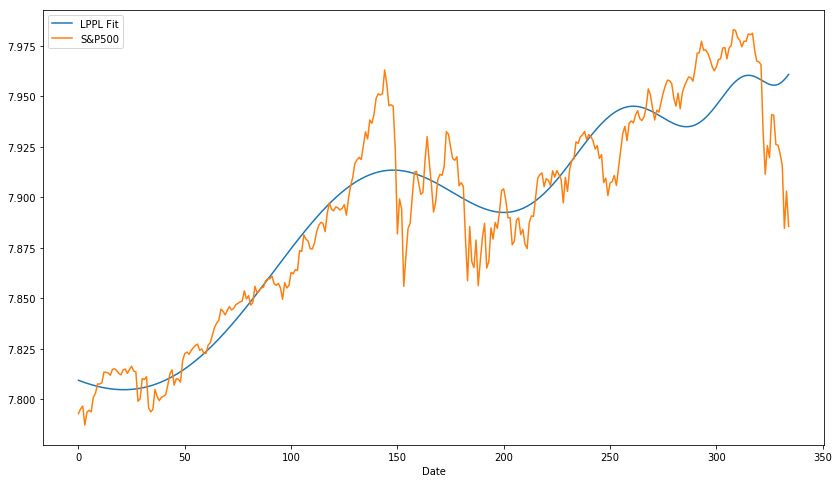

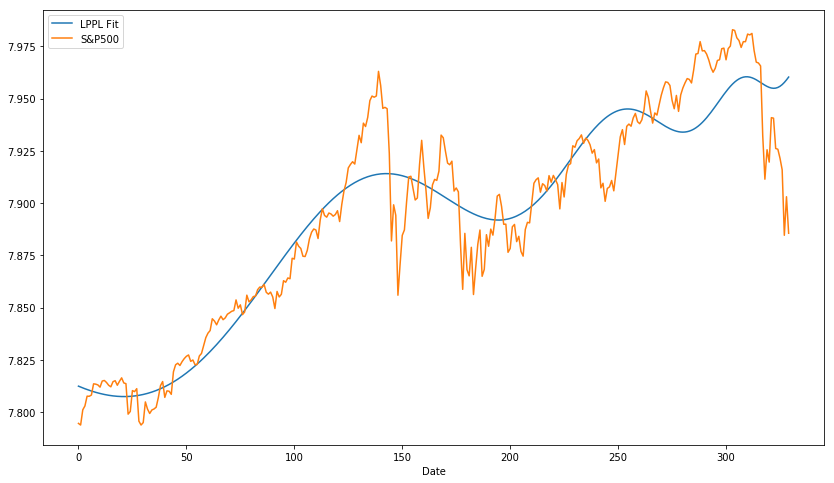

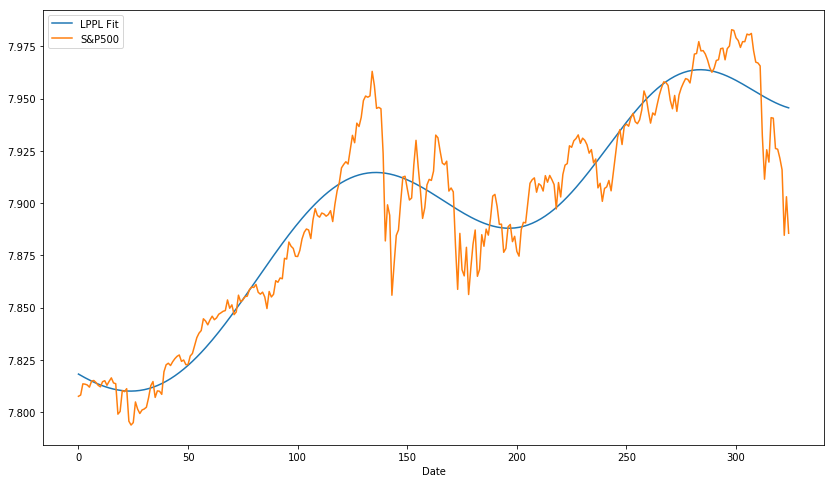

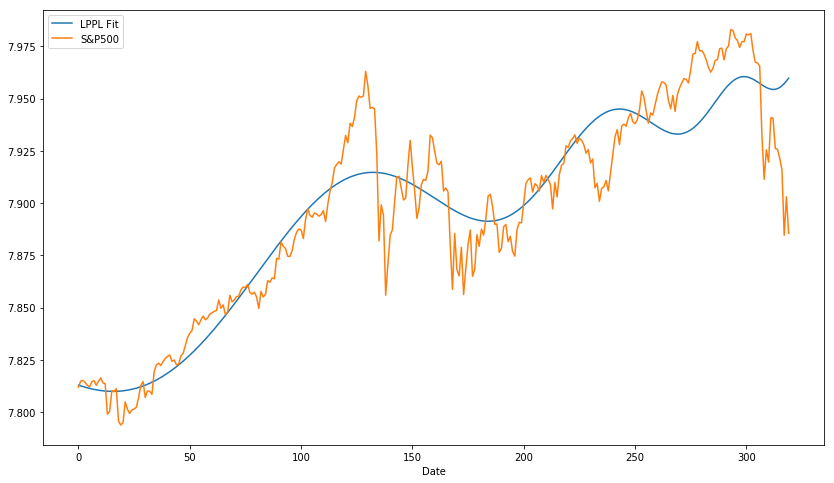

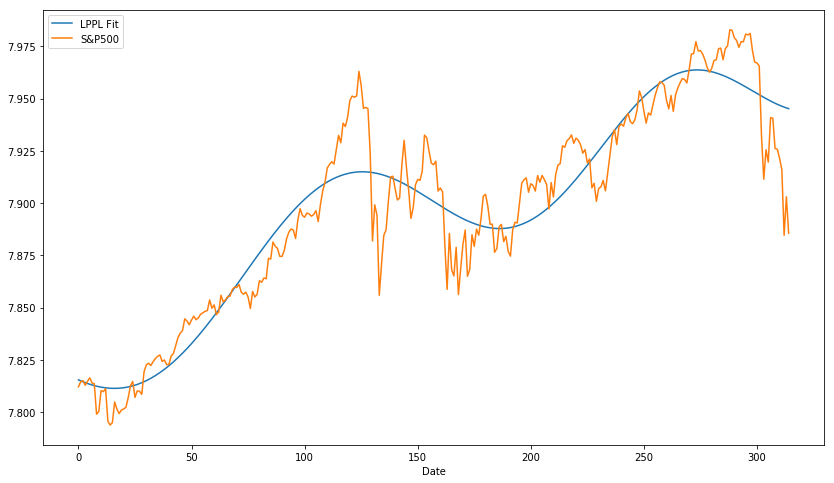

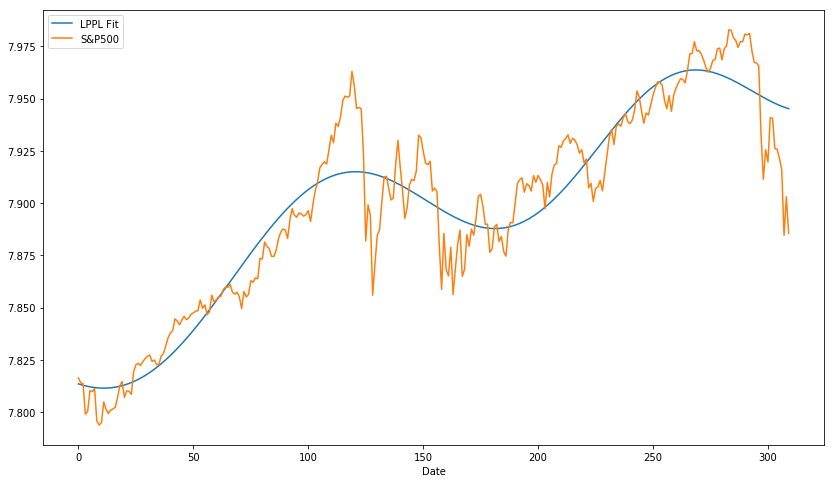

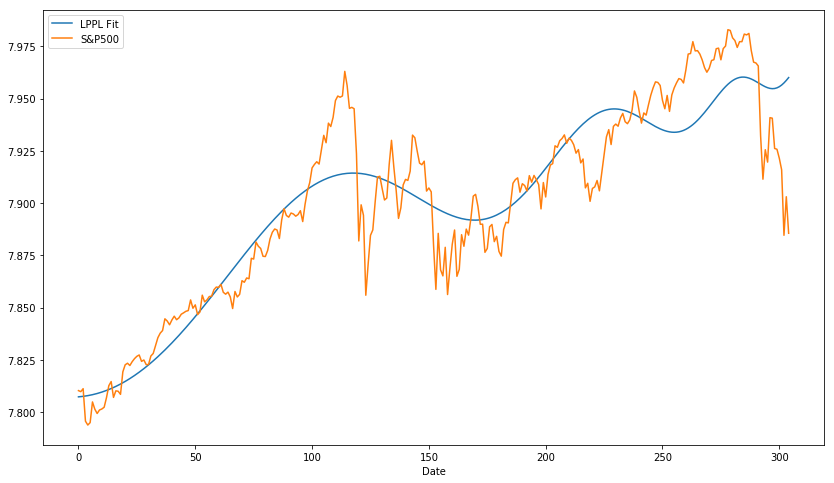

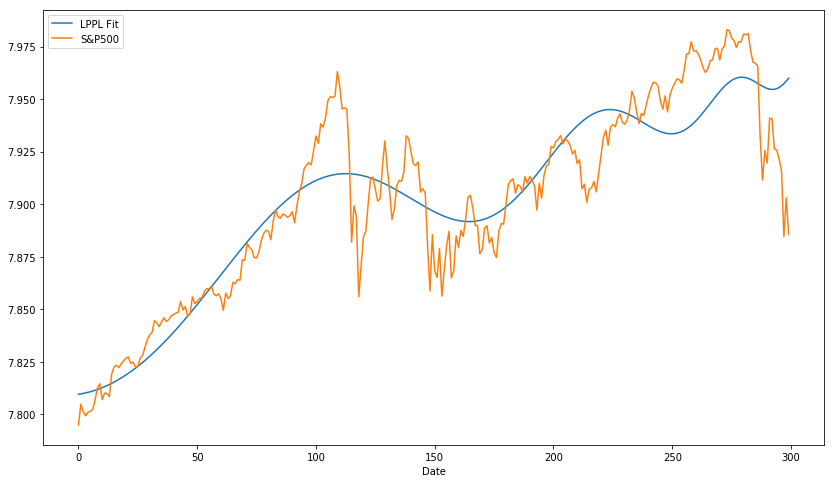

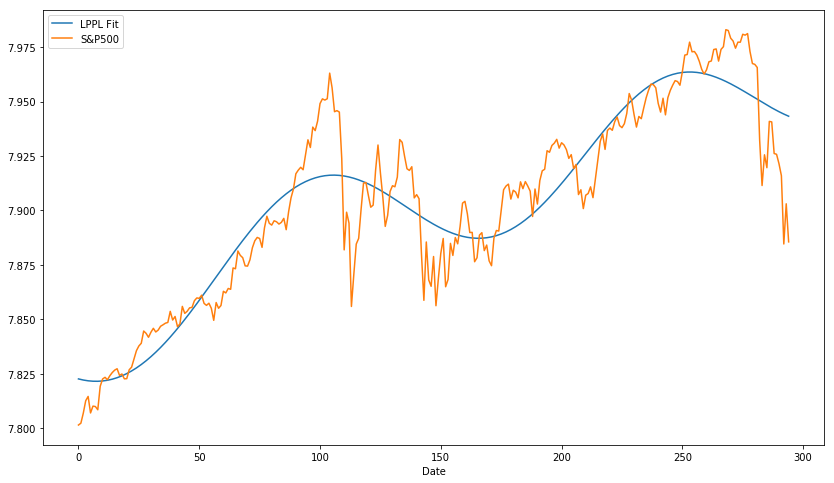

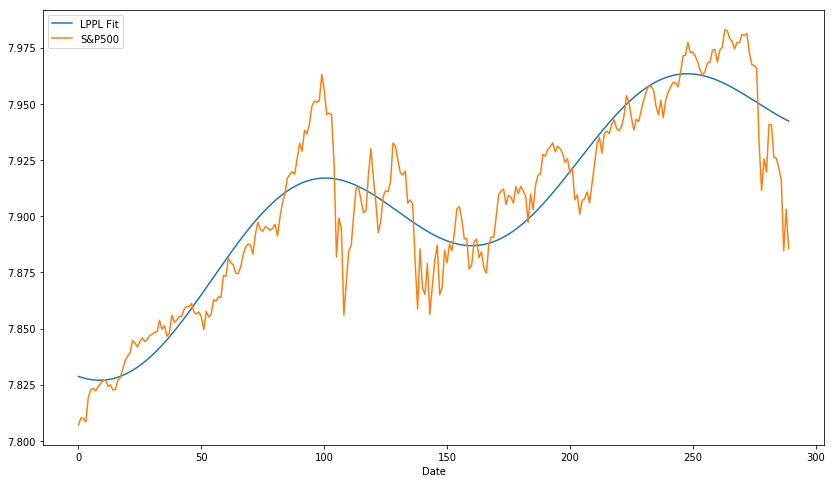

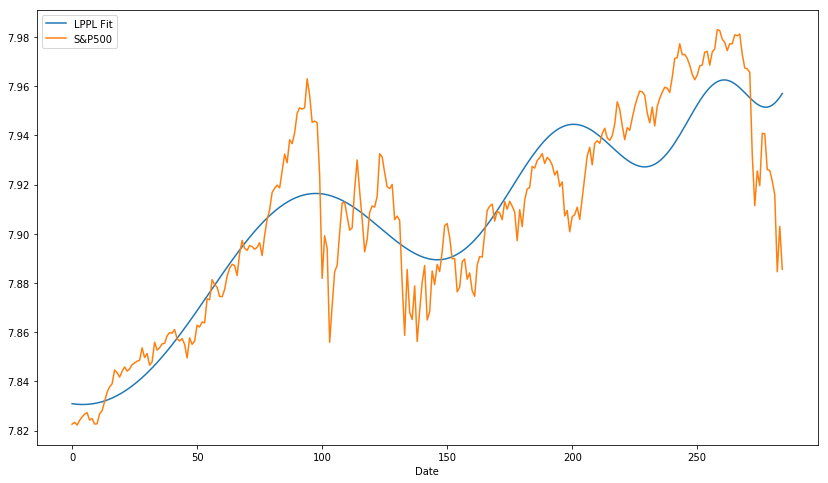

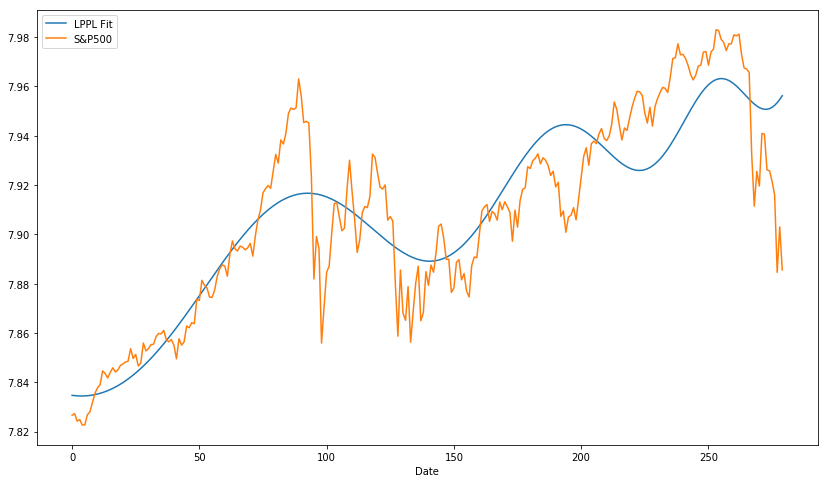

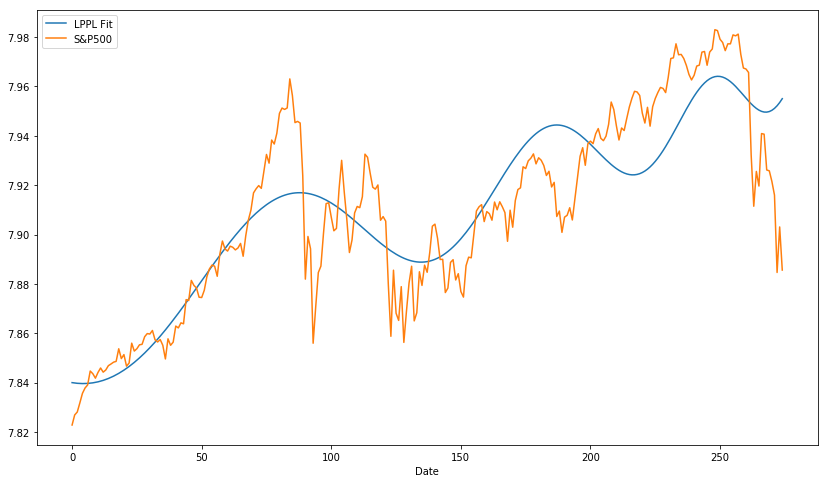

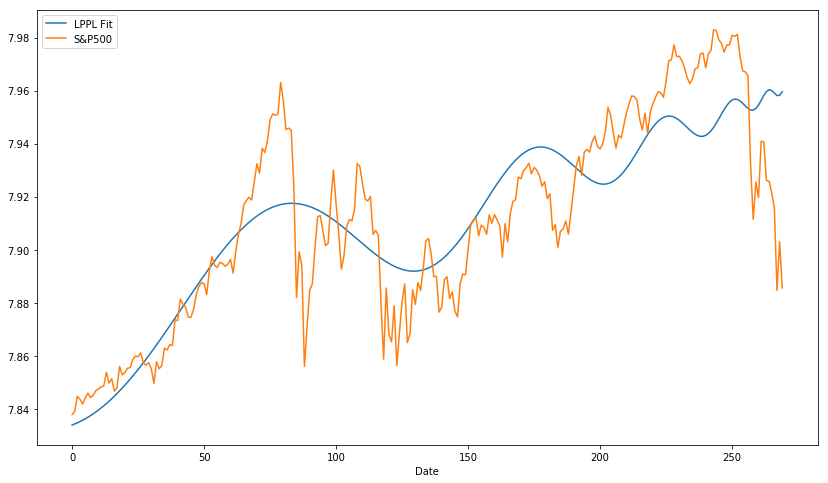

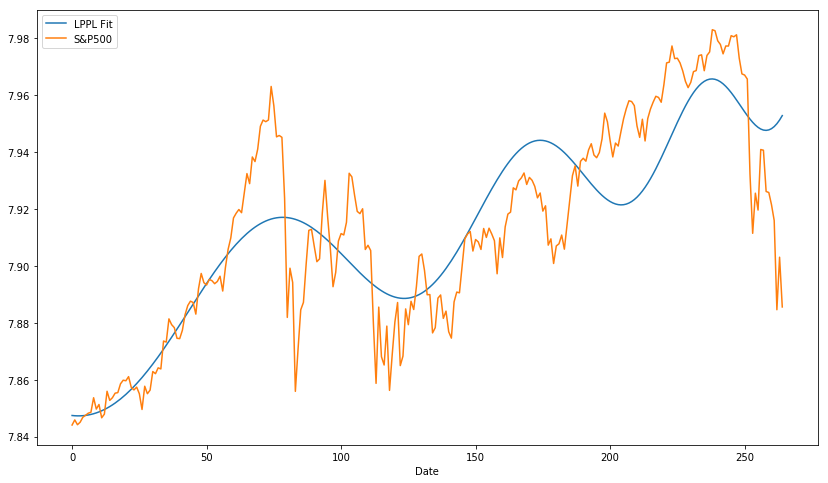

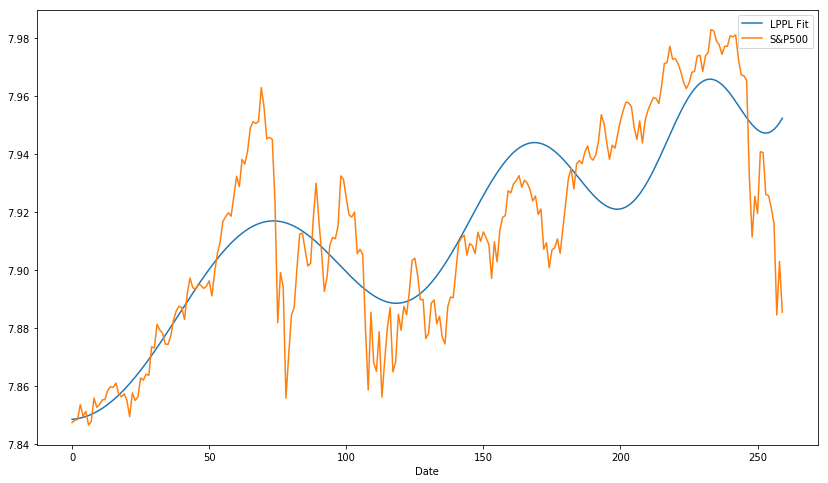

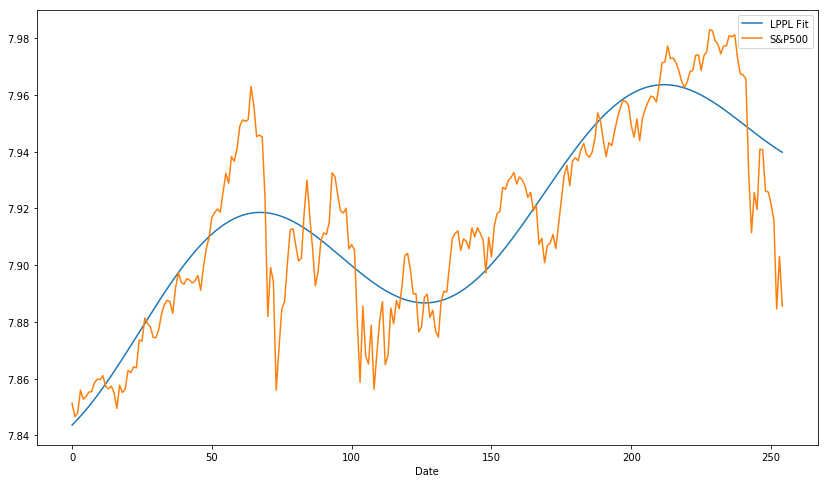

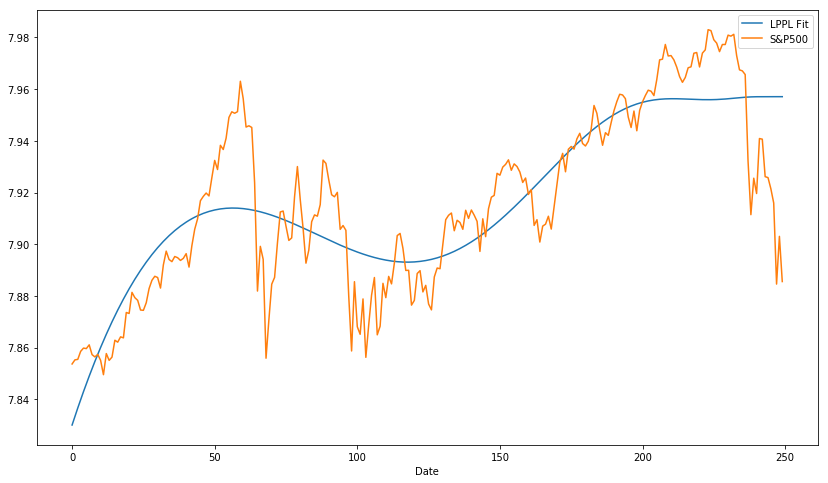

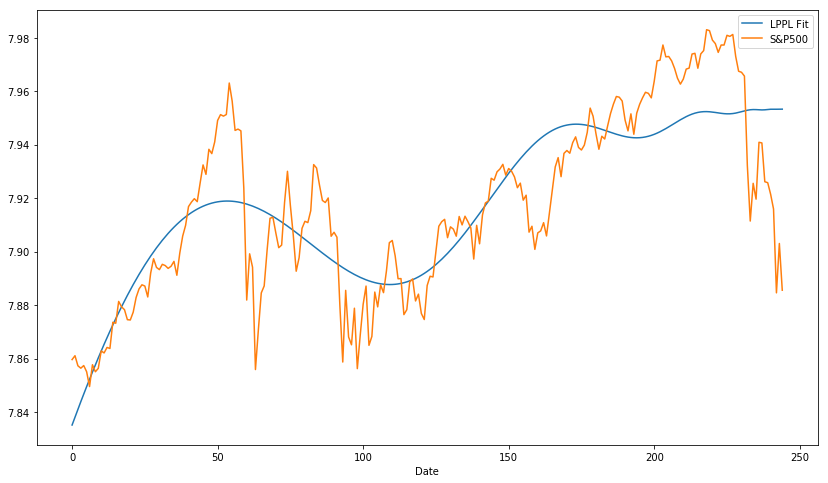

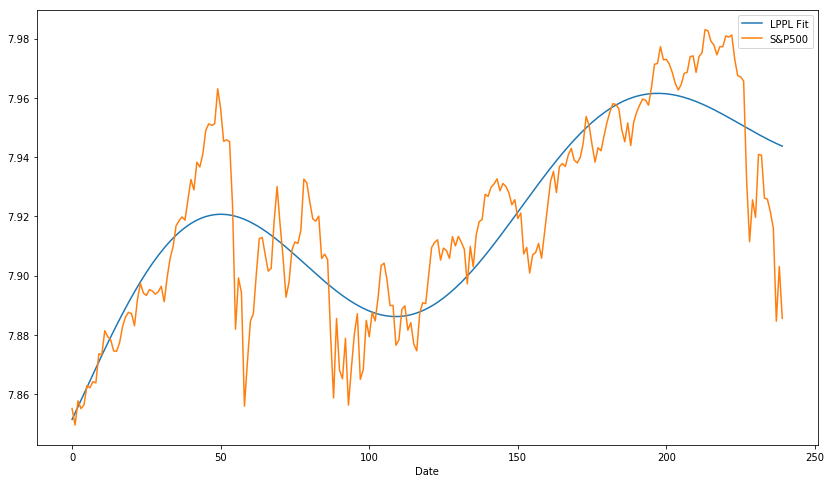

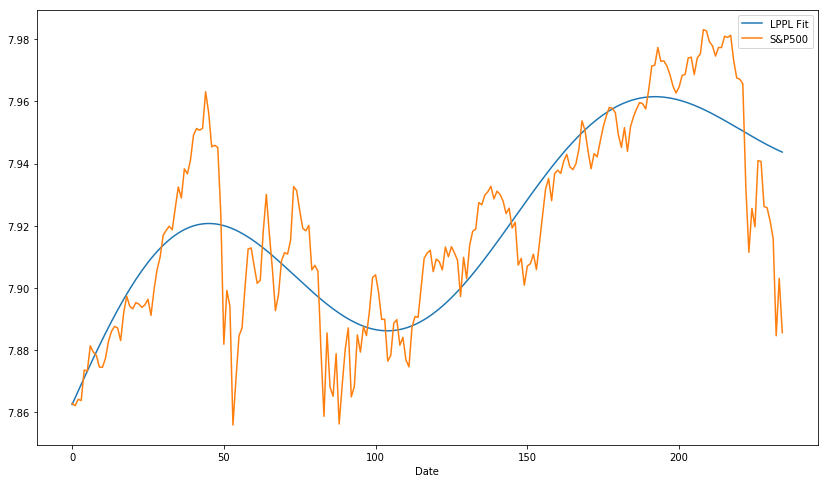

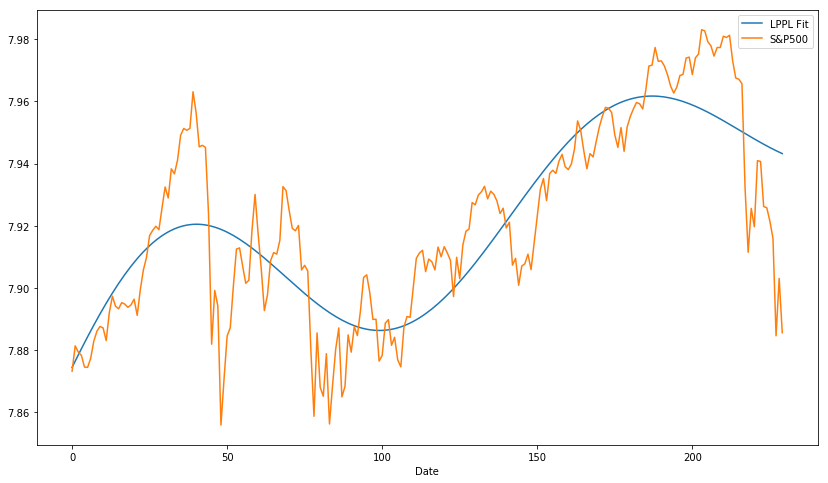

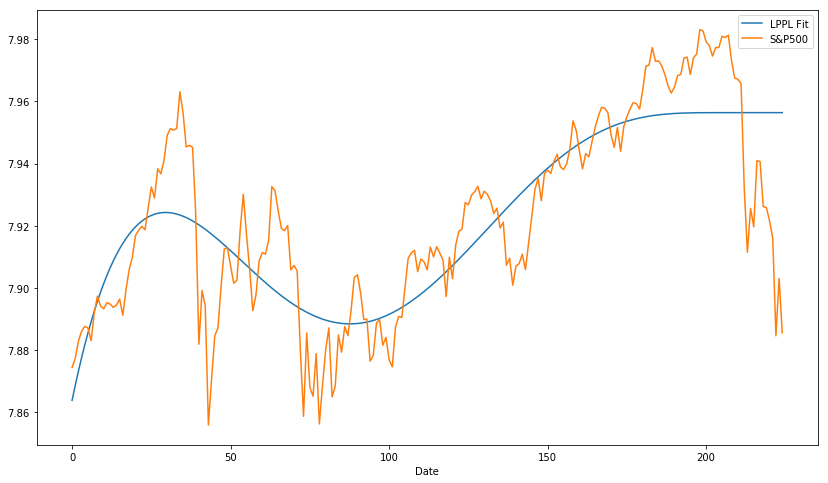

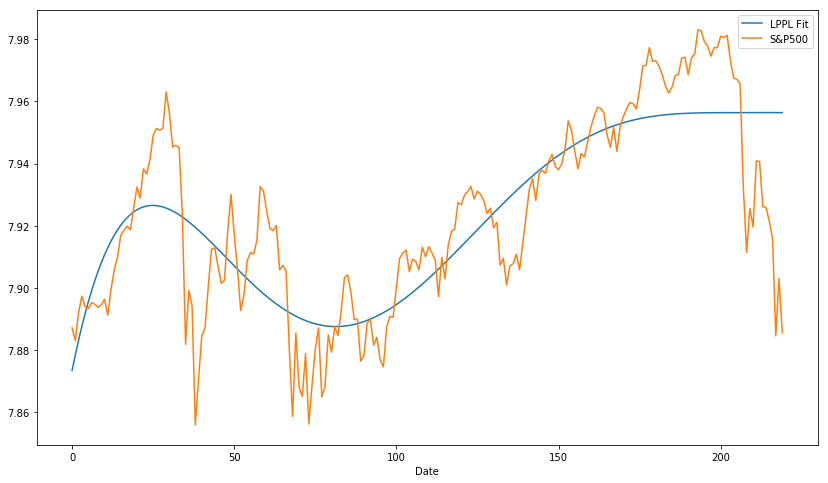

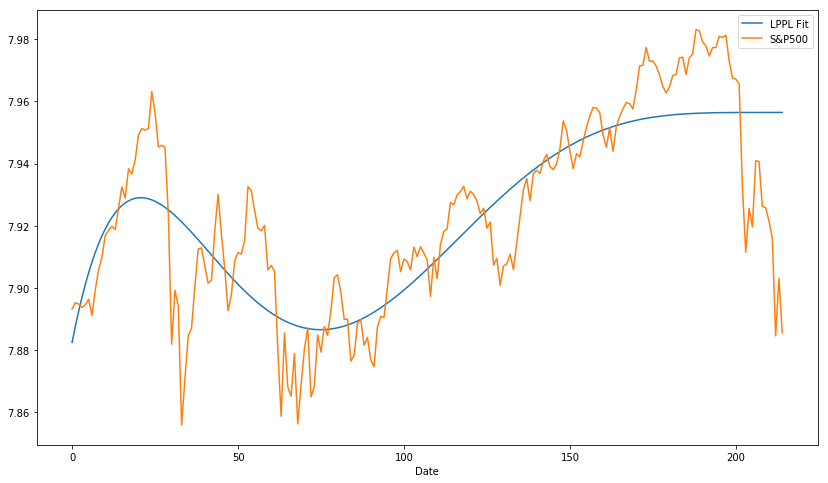

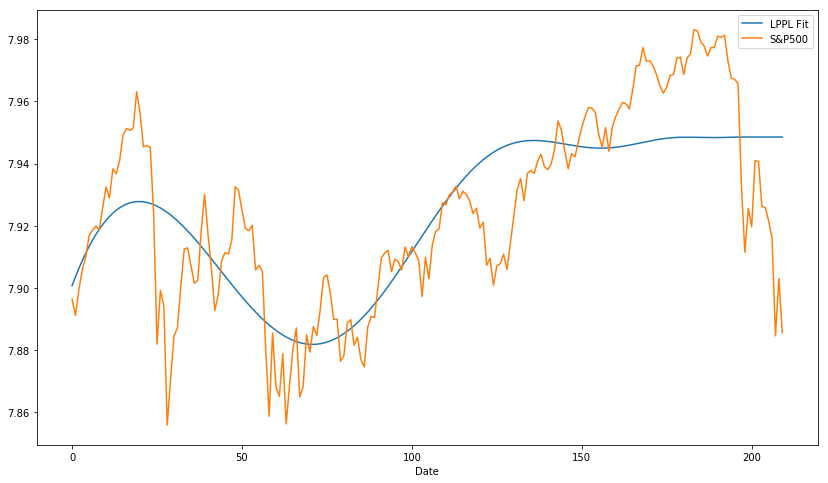

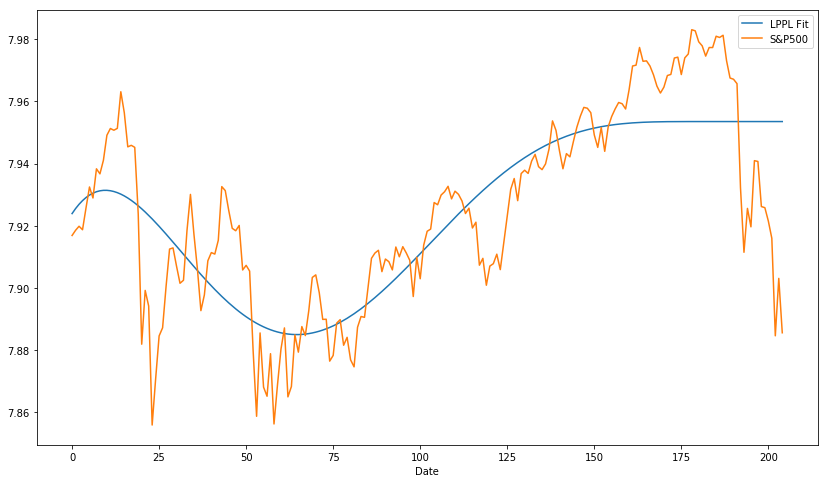

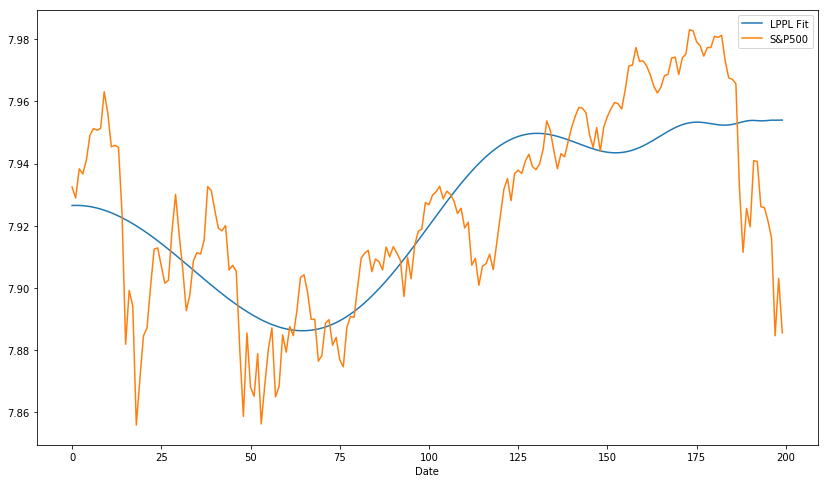

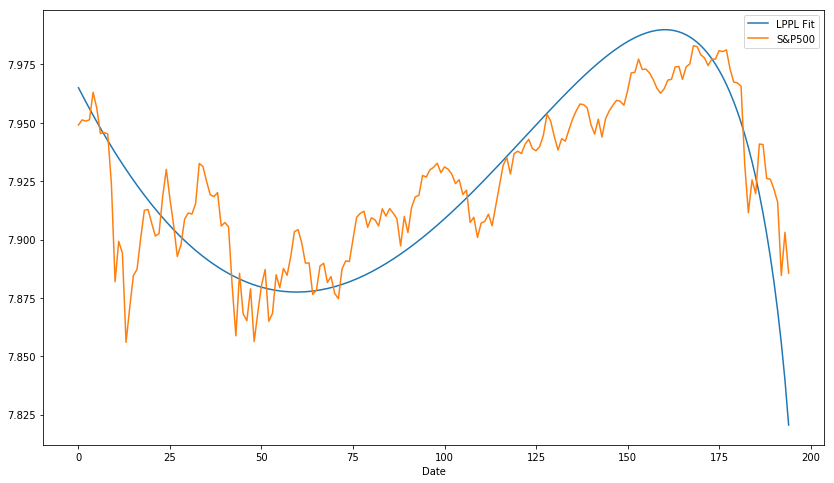

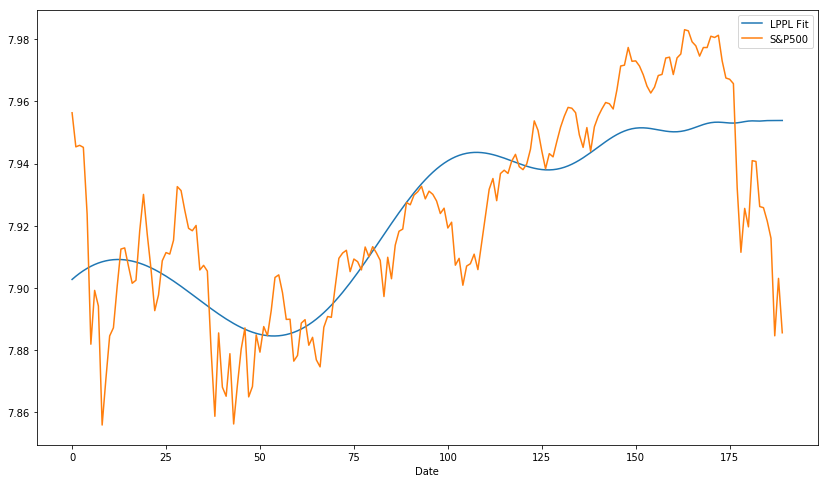

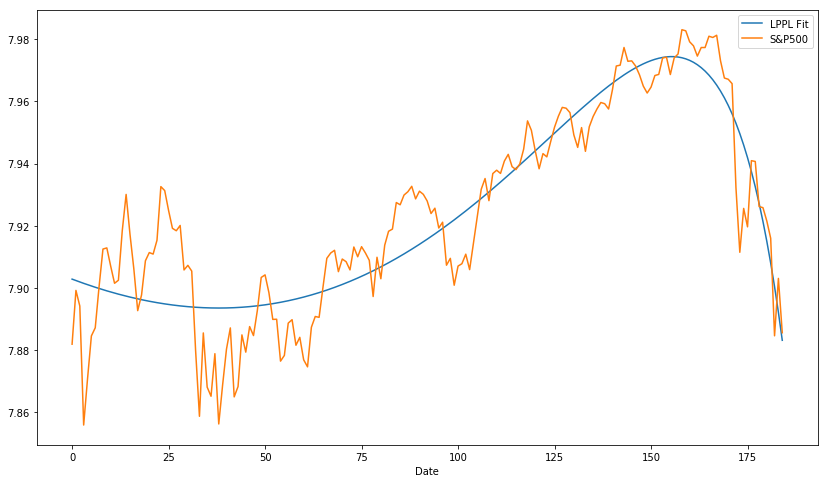

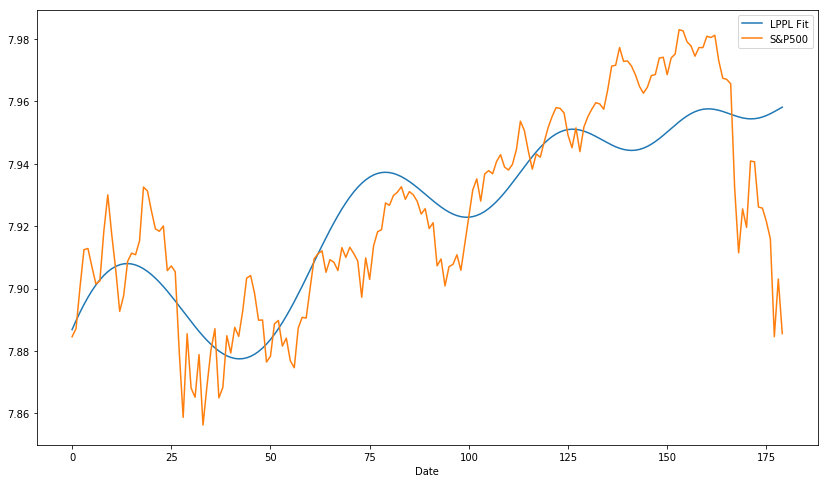

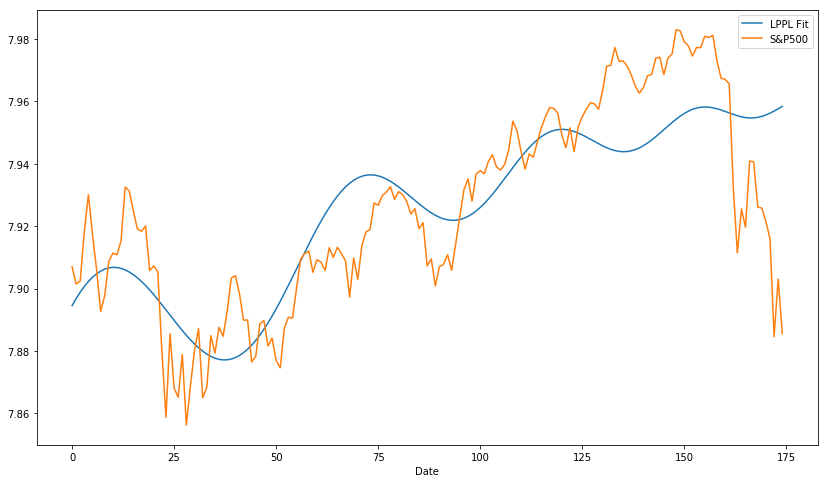

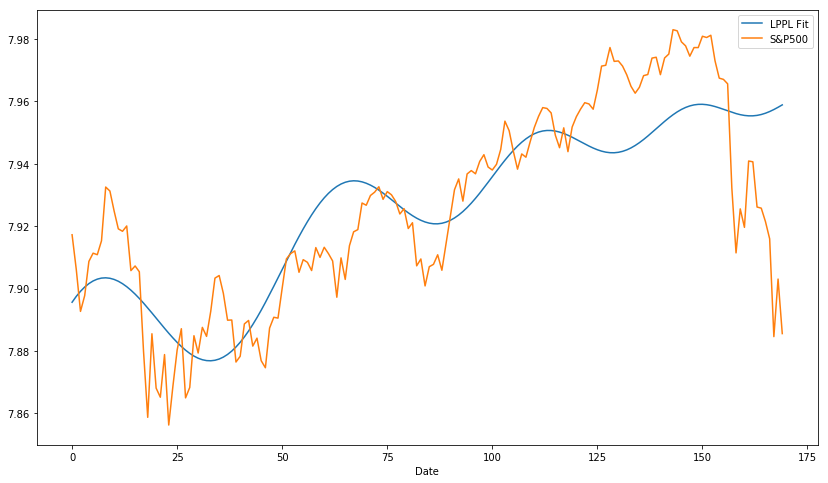

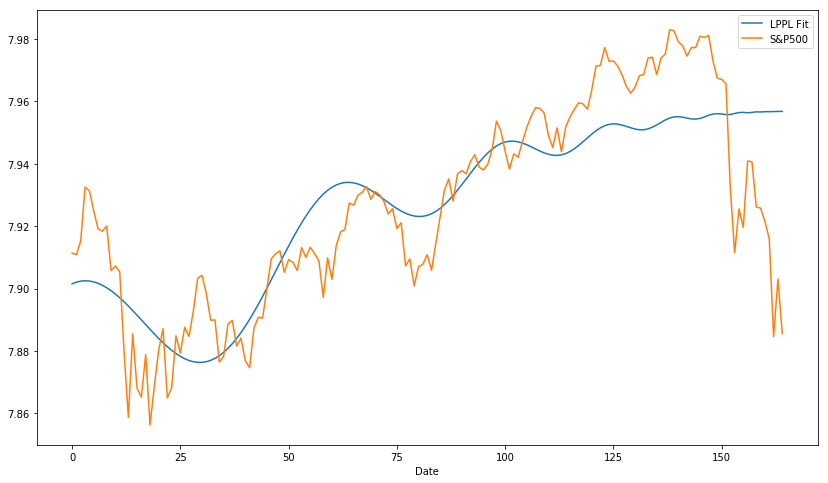

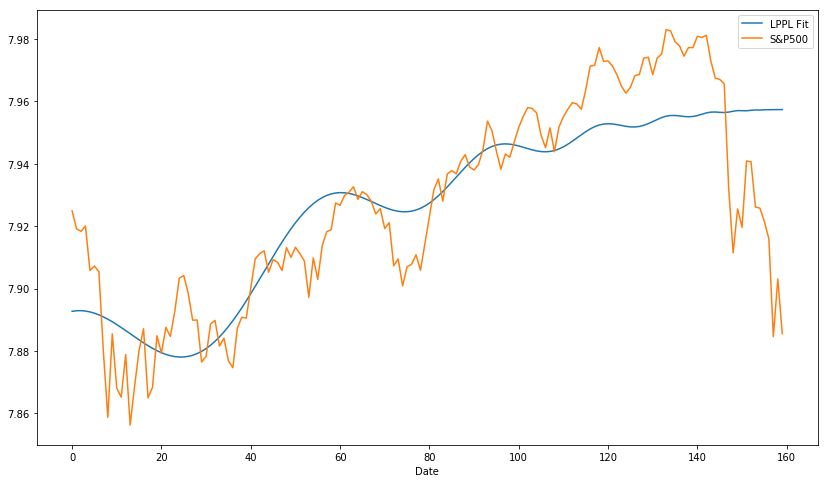

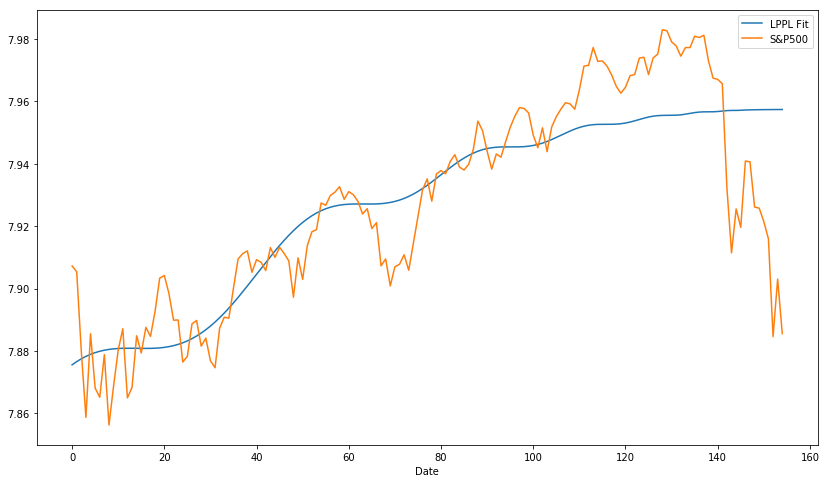

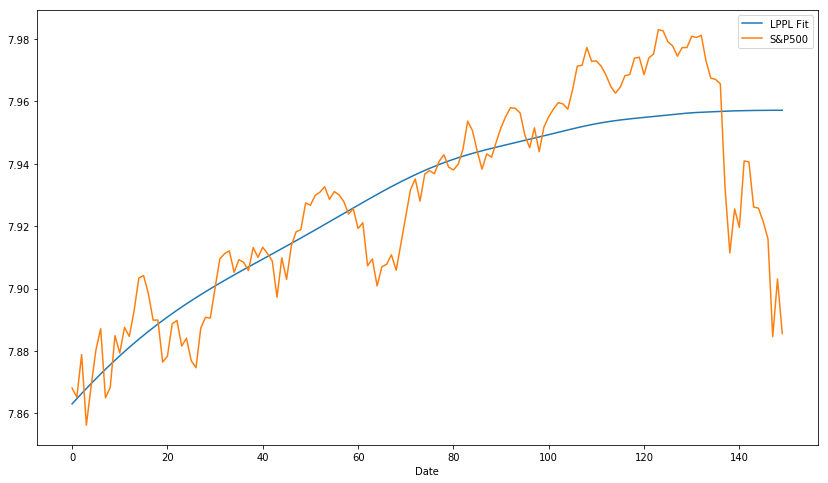

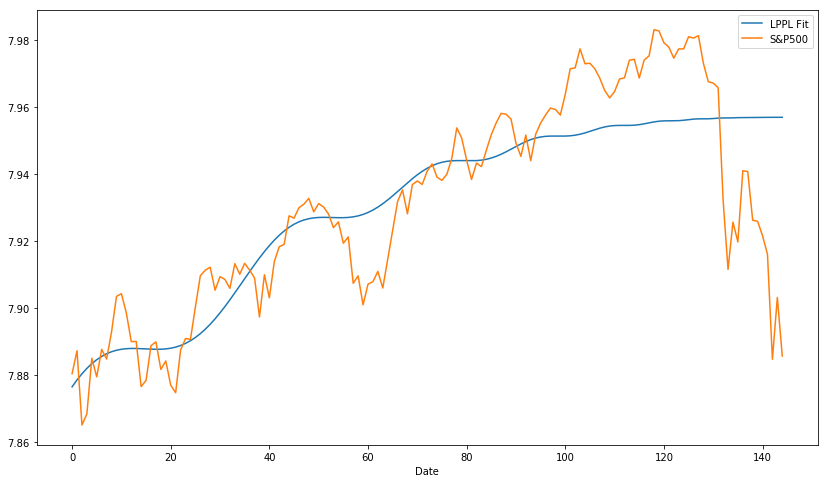

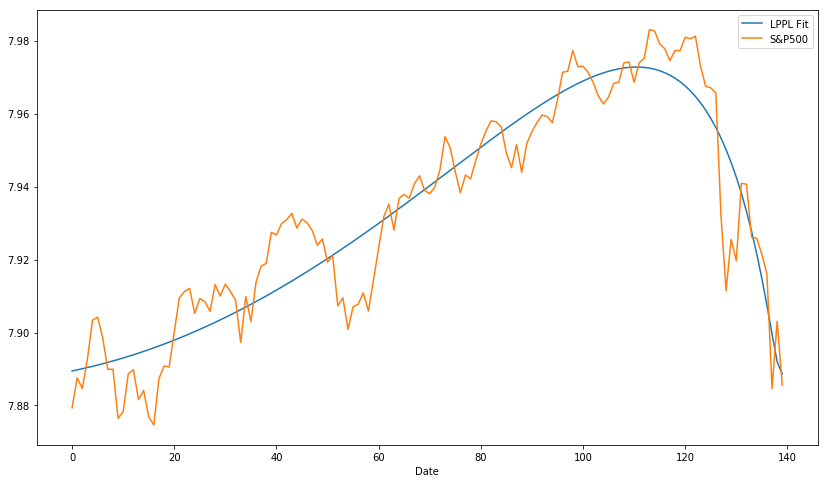

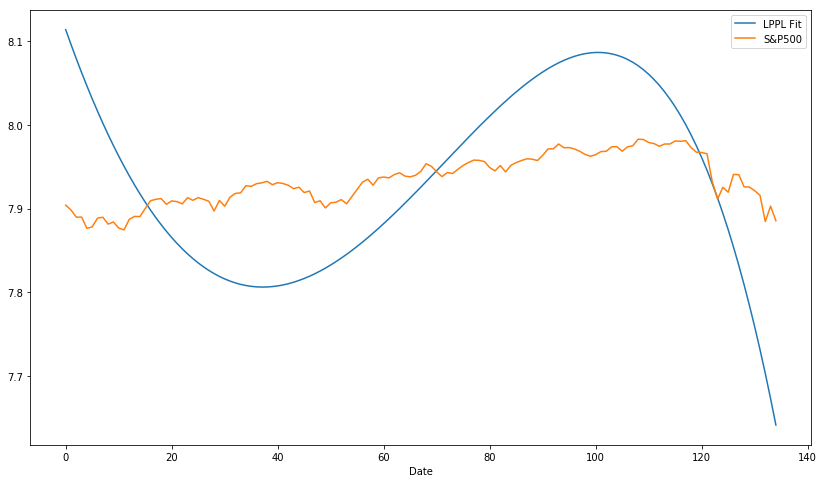

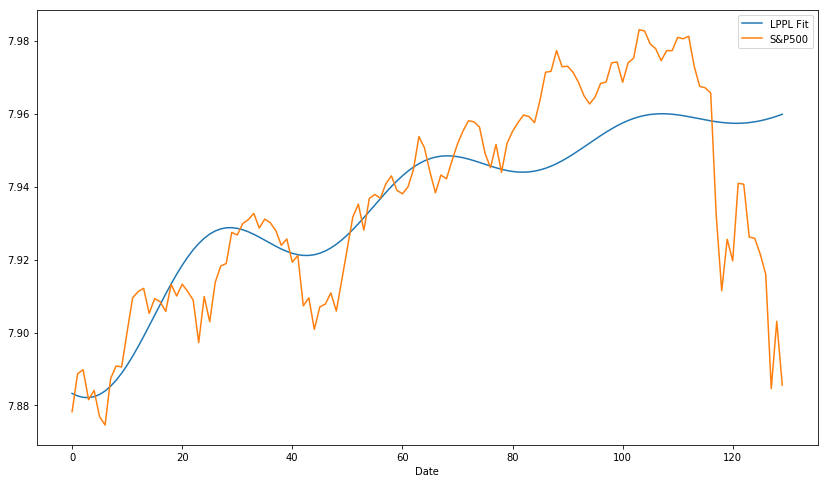

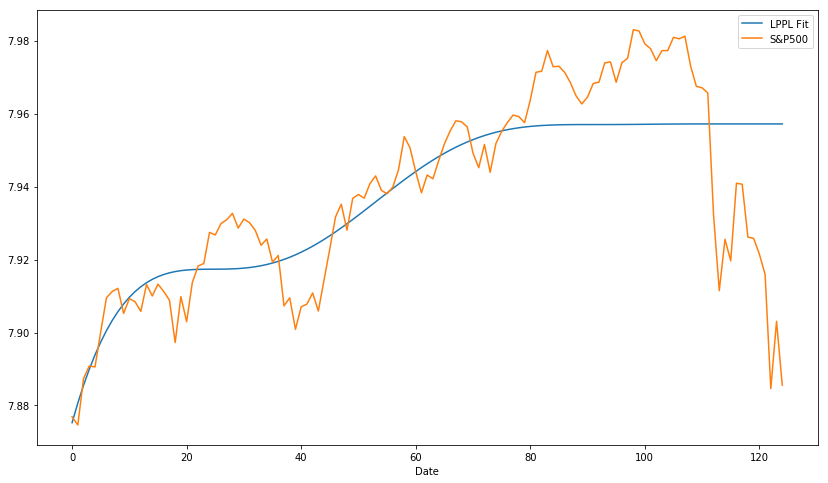

In [6]:
solutions = []
start = time.time()
for i in range(126):
    tLen = 750-(i*5)
    tradings_days_data = data.tail(tLen)
    time = np.linspace(0, tLen-1, tLen)
    price = [tradings_days_data["Adj Close"][i] for i in range(len(tradings_days_data["Adj Close"]))]
    data_series = [time, price]
    
    found_solution = False
    

    while not found_solution:
        
        # set limits for non-linear params
        limits = (
            [tLen-(tLen*0.2), tLen+(tLen*0.2)],    # Critical Time + or - .2
            [0.1, 0.9],                            # m : 0.1 ≤ m ≤ 0.9
            [6, 13],                               # ω : 6 ≤ ω ≤ 13     
        )

        # randomly choose vals for non-linear params 
        non_lin_vals = [random.uniform(a[0], a[1]) for a in limits]

        tc = non_lin_vals[0]
        m  = non_lin_vals[1] 
        w  = non_lin_vals[2]

        # params to pass to scipy.optimize
        seed = [tc, m, w]
        
        # scipy optimize minimize
        try:
            cofs = minimize(fun=func_restricted, x0=seed, args=(data_series), method='Nelder-Mead')
            
            if cofs.success:
                # determine if it falls in range:
                
                tc = cofs.x[0]
                m =  cofs.x[1]
                w =  cofs.x[2]
                
                tc_in_range = tLen-(tLen*0.05) < tc < tLen+(tLen*0.1)
                m_in_range  = 0.01 < m < 1.2
                w_in_range  = 2 < w < 25
#                 n_oscillation = (w/2)*np.log((tc - t)/(t2-t))
#                 damping = ""
#                 relative_error = ""
                
                if (tc_in_range and m_in_range and w_in_range):
                    ds_lppls_confidence = True
                else: 
                    ds_lppls_confidence = False

                solutions.append({
                    'ds_lppls_confidence': ds_lppls_confidence,
                    'cof': cofs.x,
                })
                found_solution = True
                
#                 lin_vals = matrix_equation(tc, m, w, data_series)
    
#                 a  = lin_vals[0] 
#                 b  = lin_vals[1]
#                 c1 = lin_vals[2] 
#                 c2 = lin_vals[3]
                
#                 # print it out
#                 lppl_fit = [lppl(t, tc, m, w, a, b, c1, c2) for t in data_series[0]]
#                 price_data = data_series[1]

#                 plot_data = pd.DataFrame({
#                     'Date': data_series[0],
#                     'LPPL Fit': lppl_fit,
#                     'S&P500': np.log(price_data),
#                 })
#                 plot_data = plot_data.set_index('Date')
#                 plot_data.plot(figsize=(14,8))

            print("Success: {}\nMessage: {}".format(cofs.success, cofs.message))
            print("Number of iterations: {}".format(cofs.nit))
            print("Number of evaluations of obj funcs: {}".format(cofs.nfev))
            print("-"*25)

        except Exception as e:
            print(e)

    print("iteration {}: {} trading days".format(i, tLen))
print(solutions)
end = time.time()
print(end - start)    
    